# Projet 6

In [2]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
from Package import Scripts_AnalyseMulti01 as pk_multi
from Package import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
from Package import Scripts_AnalyseMulti02_Supervised as pk_multi_sup
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from umap import UMAP
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
import re
from nltk.stem.snowball import SnowballStemmer
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic


In [3]:
from emot.emo_unicode import UNICODE_EMOJI as UNICODE_EMO# For emojis
from emot.emo_unicode import EMOTICONS_EMO# For EMOTICONS

In [4]:
from tqdm import tqdm,notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
%flake8_off

ValueError: Function <bound method VarWatcher.auto_run_flake8 of <pycodestyle_magic.VarWatcher object at 0x000001D27D0E53A0>> is not registered as a post_run_cell callback

In [9]:
# chargement des variables d'environnment
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

## Collecte des données

### Requête Via API

In [6]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. Nous utilisons cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [7]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [8]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,4):
    query = """
                {
                search(term:"restaurant",
                        location: "France",
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

nb restaurants  50
nb restaurants  100
nb restaurants  150
nb restaurants  200


In [659]:
restaurants = pd.DataFrame(restaurants)

In [660]:
restaurants.head(2)

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                                                   photos  \
0  [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1  [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   

                                                                                               reviews  
0  [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1  [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...

## Construction des bases de données

Nous scindons notre fichier en deux afin de traiter le texte et les photos séparément.

In [687]:
df = restaurants.copy()

In [688]:
df.head(2)

id                           name  \
0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                                                   photos  \
0  [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1  [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   

                                                                                               reviews  
0  [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1  [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...

In [689]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                    text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rating  
0         5  
1         5  
2         5  
3         5  
4         5  
..      ...  
195       5  
196       5  
197       5  
198       5  
199       5  

[200 rows x 3 columns]

In [690]:
df

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                                                                                                 reviews  
0    [{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! 

We started off with the ...  
1    [{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale N...  
2    [{'id': 'WMRKQUUR3BmjV_EZg7zVfw', 'text': 'this is for a review from 2019, this place is perfect...  
3    [{'id': 'un3pGCn6lKHDbaI-hsrk-A', 'text': 'When I visited Paris last week, I had stopped by here...  
4    [{'id': '3u0PefxOlwysE22VZa9OSA', 'text': 'Based on some research, we decided to book a reservat...  
..                                                                                                   ...  
195  [{'id': 'JIiCwKFnpBL76fOX79pwRg', 'text': 'Great service and excellent food! I highly recommend ...  
196  [{'id': 'vs1Aeepu-UrpNZyTzaQxwg', 'text': 'One of the best breakfasts I've ever had. 
And that w...  
197  [{'id': '_pHOfFvvdLdeRpZ-OTnQoA', 'text': 'Holy crap.  This place is a must do on your European ...  
198  [{'id': 'bJNWq9qdikfH-l3t6P7xfA', 'text': 'As a single female, this is a comfortable and friendl...  
199  [{'id': 'U05nUrtYO9-qixA3PanI7A', 'text': 'Absolutely, hands down the best meal I have ever had....  

[200 rows x 4 columns]

In [691]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)


In [692]:
df.columns

Index(['id', 'name', 'photos', 'id', 'text', 'rating'], dtype='object')

In [693]:
df.columns = ['id', 'name', 'photos', 'rw_id', 'rw_text', 'rw_rating']

In [694]:
df.head(2)

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                      rw_id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                 rw_text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rw_rating  
0            5  
1            5  
2            5  
3            5  
4            5  
..         ...  
195          5  
196          5  
197          5  
198          5  
199          5  

[200 rows x 6 columns]

### Exportons les données en csv

In [695]:
df.to_csv('output/restaurants_v2.csv')

In [696]:
df

id                           name  \
0    -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1    IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   
2    WHHt_Jb8Tgidn9mW7oDnIg                 La Coïncidence   
3    cEjF41ZQB8-SST8cd3EsEw               L'Avant Comptoir   
4    ctP4c3mwVO5oOzLI48LtuQ                Les Antiquaires   
..                      ...                            ...   
195  4kfOSgh1GlUjcRCaYgDV8g                       Le Louis   
196  uSbrVw_sVHOthg63MwJBxA                      Zia Paris   
197  hiqQTVdbpcQtgCqu2M6PqQ                        Le Cinq   
198  3K6B3W9N4wUD7l3GT7YUsg                  Le Poulailler   
199  eoUCWArm9w8kXtyA0N7MoQ                          ASPIC   

                                                                     photos  \
0    [https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg]   
1    [https://s3-media4.fl.yelpcdn.com/bphoto/J9RByC4HuTubBKX77PYeEg/o.jpg]   
2    [https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgEgbd5TLlqZYT_dezg/o.jpg]   
3    [https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxgmpUcAUOZKdxypwSw/o.jpg]   
4    [https://s3-media3.fl.yelpcdn.com/bphoto/aBwaSVkWWFKTGl1gM8N90g/o.jpg]   
..                                                                      ...   
195  [https://s3-media2.fl.yelpcdn.com/bphoto/zTG7LJ3ChQwZ-5rp4fF-dA/o.jpg]   
196  [https://s3-media2.fl.yelpcdn.com/bphoto/trP-Cj9pHYKE5VuaabP6jQ/o.jpg]   
197  [https://s3-media4.fl.yelpcdn.com/bphoto/hWCc8_pvL1X4hQ_hnz7gnQ/o.jpg]   
198  [https://s3-media2.fl.yelpcdn.com/bphoto/Q8VtWRo5vKlxLCzu8RhXsg/o.jpg]   
199  [https://s3-media2.fl.yelpcdn.com/bphoto/QQZtg7Ashz486V3CQ4AqnQ/o.jpg]   

                      rw_id  \
0    aGP7nLwEQOUg64jKP8ebsw   
1    -to6adg_kucf1SgQckgJXw   
2    WMRKQUUR3BmjV_EZg7zVfw   
3    un3pGCn6lKHDbaI-hsrk-A   
4    3u0PefxOlwysE22VZa9OSA   
..                      ...   
195  JIiCwKFnpBL76fOX79pwRg   
196  vs1Aeepu-UrpNZyTzaQxwg   
197  _pHOfFvvdLdeRpZ-OTnQoA   
198  bJNWq9qdikfH-l3t6P7xfA   
199  U05nUrtYO9-qixA3PanI7A   

                                                                                                 rw_text  \
0    My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love th...   
1    This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or ...   
2    this is for a review from 2019, this place is perfect. would recommend 100%. prices are great, f...   
3    When I visited Paris last week, I had stopped by here by a recommendation of a friend and also r...   
4    Based on some research, we decided to book a reservation here for a meal on our first night in P...   
..                                                                                                   ...   
195  Great service and excellent food! I highly recommend this quaint little restaurant. Be sure to s...   
196  One of the best breakfasts I've ever had. \nAnd that was just the start. \nThe location is great...   
197  Holy crap.  This place is a must do on your European fine dining bucket list.  Located at the fa...   
198  As a single female, this is a comfortable and friendly place to enjoy. I only had the appetizers...   
199  Absolutely, hands down the best meal I have ever had. My wife and I booked this dinner for our a...   

     rw_rating  
0            5  
1            5  
2            5  
3            5  
4            5  
..         ...  
195          5  
196          5  
197          5  
198          5  
199          5  

[200 rows x 6 columns]

### Import des données CSV

In [19]:
df = pd.read_csv('output/restaurants_v2.csv')

In [20]:
df.head(2)
#del df["Unnamed: 0"]

Unnamed: 0                      id                           name  \
0           0  -0iLH7iQNYtoURciDpJf6w  Le Comptoir de la Gastronomie   
1           1  IU9_wVOGBKjfqTTpAXpKcQ           Bistro des Augustins   

                                              photos                   rw_id  \
0  ['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQ...  aGP7nLwEQOUg64jKP8ebsw   
1  ['https://s3-media4.fl.yelpcdn.com/bphoto/J9RB...  -to6adg_kucf1SgQckgJXw   

                                             rw_text  rw_rating  
0  My favorite meal in Paris! \n\nWe started off ...          5  
1  This is a small bar/restaurant closed to Cathé...          5

## Import des données Json

In [21]:
filename = "input\yelp_dataset\yelp_academic_dataset_review.json"
reviews_json = pd.read_json(filename, lines=True, nrows=50000)

In [22]:
#reviews_json = reviews_json.loc[reviews_json["stars"]<=1]

In [23]:
reviews_json.head(2)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18

In [24]:
reviews_json.shape

(50000, 9)

In [25]:
reviews_json[['review_id', 'business_id']].duplicated().sum()

0

In [97]:
filename = "input\yelp_dataset\yelp_academic_dataset_business.json"
bs_json = pd.read_json(filename, lines=True)

In [27]:
bs_json

business_id                      name  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2       tUFrWirKiKi_TAnsVWINQQ                    Target   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   
...                        ...                       ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   

                                address           city state postal_code  \
0                1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1       87 Grasso Plaza Shopping Center         Affton    MO       63123   
2                  5255 E Broadway Blvd         Tucson    AZ       85711   
3                           935 Race St   Philadelphia    PA       19107   
4                         101 Walnut St     Green Lane    PA       18054   
...                                 ...            ...   ...         ...   
150341                3388 Gateway Blvd       Edmonton    AB     T6J 5H2   
150342               2813 Bransford Ave      Nashville    TN       37204   
150343           6020 E 82nd St, Ste 46   Indianapolis    IN       46250   
150344                     2472 Troy Rd   Edwardsville    IL       62025   
150345            238 Apollo Beach Blvd   Apollo beach    FL       33572   

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197    5.0             7        0   
1       38.551126  -90.335695    3.0            15        1   
2       32.223236 -110.880452    3.5            22        0   
3       39.955505  -75.155564    4.0            80        1   
4       40.338183  -75.471659    4.5            13        1   
...           ...         ...    ...           ...      ...   
150341  53.468419 -113.492054    3.0            13        1   
150342  36.115118  -86.766925    4.0             5        1   
150343  39.908707  -86.065088    3.5             8        1   
150344  38.782351  -89.950558    4.0            24        1   
150345  27.771002  -82.394910    4.5             9        1   

                                               attributes  \
0                           {'ByAppointmentOnly': 'True'}   
1                  {'BusinessAcceptsCreditCards': 'True'}   
2       {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3       {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4       {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   
...                                                   ...   
150341  {'ByAppointmentOnly': 'False', 'RestaurantsPri...   
150342  {'BusinessAcceptsCreditCards': 'True', 'Restau...   
150343  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
150344  {'BusinessParking': '{'garage': False, 'street...   
150345  {'WheelchairAccessible': 'True', 'BusinessAcce...   

                                               categories  \
0       Doctors, Traditional Chinese Medicine, Naturop...   
1       Shipping Centers, Local Services, Notaries, Ma...   
2       Department Stores, Shopping, Fashion, Home & G...   
3       Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                               Brewpubs, Breweries, Food   
...                                                   ...   
150341                         Nail Salons, Beauty & Spas   
150342  Pets, Nurseries & Gardening, Pet Stores, Hobby...   
150343  Shopping, Jewelry, Piercing, Toy Stores, Beaut...   
150344  Fitness/Exercise Equipment, Eyewear & Optician...   
150345  Beauty & Spas, Permanent Makeup, Piercing, Tattoo   

                                                    hours  
0                                                    None  
1       {'Monday': '0:0-0:0', 'Tuesday': '

In [28]:
bs_json[['business_id']].duplicated().sum()

0

In [29]:
bs_json.head(2)

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   

                               attributes  \
0           {'ByAppointmentOnly': 'True'}   
1  {'BusinessAcceptsCreditCards': 'True'}   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...

In [30]:
gc.collect()

0

Nous conservons les restaurants qui sont ouverts.

In [31]:
bs_json = bs_json[["business_id", "name", "is_open"]].loc[bs_json["is_open"]==1]

Et nous réalisons une jointure pour relier le nom du restaurant et les commentaires

In [32]:
df_json = reviews_json.merge(bs_json, how="inner", on="business_id")

In [33]:
df_json.head(2)

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  VJxlBnJmCDIy8DFG0kjSow  Iaee7y6zdSB3B-kRCo4z1w  XQfwVwDr-v0ZS3_CbbE5Xw   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      2       0      0     0   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  This is the second time we tried turning point... 2017-05-13 17:06:55   

                           name  is_open  
0  Turning Point of North Wales        1  
1  Turning Point of North Wales        1

Nous filtrons pour obtenir les mêmes colonnes que l'API.

In [34]:
reviews_json_filt = df_json[["review_id", "stars", "text"]]
reviews_json_filt.columns = ["rw_id", "rw_rating", "rw_text"]

In [35]:
reviews_json_filt

rw_id  rw_rating  \
0      KU_O5udG6zpxOg-VcAEodg          3   
1      VJxlBnJmCDIy8DFG0kjSow          2   
2      S6pQZQocMB1WHMjTRbt77A          4   
3      WqgTKVqWVHDHjnjEsBvUgg          3   
4      M0wzFFb7pefOPcxeRVbLag          2   
...                       ...        ...   
38300  ecIkOSZyvPeQ-f5AvzYIGA          5   
38301  nP3X1Bjc8CPpwpGlK70vkA          1   
38302  BFkiGDAdyyWnHMz5q48DBA          3   
38303  9EPrNddaEgTtivQSigWzEg          5   
38304  36JEqVaG5KXJ5FFVGFTcvA          5   

                                                 rw_text  
0      If you decide to eat here, just be aware it is...  
1      This is the second time we tried turning point...  
2      The place is cute and the staff was very frien...  
3      We came on a Saturday morning after waiting a ...  
4      Mediocre at best. The decor is very nice, and ...  
...                                                  ...  
38300  This place is great - played there for 4 hours...  
38301  Nope, wanted donair, read the review, only 2. ...  
38302  I've been here about 3 times. I never go when ...  
38303  I was referred to Enterprise Car Sales by a co...  
38304  Since I was a child I've been visiting after h...  

[38305 rows x 3 columns]

In [36]:
reviews = df[["rw_id", "rw_rating", "rw_text"]].copy()

Nous concaténons les données du fichier json et les données de l'API

In [37]:
reviews_ct = pd.concat([reviews, reviews_json_filt])


Nous vérifions s'il existe des doublons.

In [38]:
sum(reviews_ct.duplicated())

0

In [39]:
reviews_ct["rw_rating"].unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [40]:
reviews = reviews_ct.copy()

In [ ]:
reviews = reviews.sample(3000)

In [98]:
filename = "input\\yelp_photos\\photos.json"
photos_json = pd.read_json(filename, lines=True, nrows=25000)

In [99]:
photos_json.groupby("label").count()

photo_id  business_id  caption
label                                  
drink        1975         1975     1975
food        13453        13453    13453
inside       7082         7082     7082
menu          219          219      219
outside      2271         2271     2271

In [100]:
photos_json_filt = photos_json.groupby('label').sample(200)

In [101]:
photos_json_filt.groupby('label').count()

photo_id  business_id  caption
label                                  
drink         200          200      200
food          200          200      200
inside        200          200      200
menu          200          200      200
outside       200          200      200

In [19]:
photos = df[["id", "photos"]]

NameError: name 'df' is not defined

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

Regardons le nombre de commentaire par note. Traçons un diagramme en barre

In [115]:
import plotly.express as px

t = pd.crosstab(reviews["rw_rating"], "freq", normalize=True)
t = t.assign(Note=t.index, Fréquences=100 * t.freq)
fig = px.bar(t, x='Note', y='Fréquences',
             hover_data=['Note', 'Fréquences'],  height=400, title="Répartition des commentaires en fonction des notes",
             labels=dict(Note="Note", Fréquences="Fréquence (%)"))
fig.update_traces(marker_color='rgb(96,27,0)', 
                  marker_line_width=1.5, opacity=0.6)
plt.figure(figsize=(8, 13))
fig.show()

In [118]:
# color 'rgb(96,27,0)'
#graph_int_bar(reviews["rw_rating"], 'Note', 'Répartition des commentaires en fonction des notes', 'rgb(96,27,0)')
def graph_int_bar(df_var, labelx, title_i, color_i):   
    t = pd.crosstab(df_var, "freq", normalize=True)
    t = t.assign(Note=t.index, Fréquences=100 * t.freq)
    # plt.figure(figsize=fig_i)
    fig = px.bar(t, x='Note', y='Fréquences',
                hover_data=['Note', 'Fréquences'],  height=400, title=title_i,
                labels=dict(Note=labelx, Fréquences="Fréquence (%)"))
    fig.update_traces(marker_color=color_i, 
                    marker_line_width=1.5, opacity=0.6)
    plt.figure(figsize=(8, 13))
    fig.show()

In [214]:
reviews['rw_rating'].describe()

count    401120.000000
mean          3.856938
std           1.409803
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rw_rating, dtype: float64

Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [24]:
reviews

rw_id  rw_rating  \
0       aGP7nLwEQOUg64jKP8ebsw          5   
1       -to6adg_kucf1SgQckgJXw          5   
2       WMRKQUUR3BmjV_EZg7zVfw          5   
3       un3pGCn6lKHDbaI-hsrk-A          5   
4       3u0PefxOlwysE22VZa9OSA          5   
...                        ...        ...   
400915  bOrQZsNrbd966S4oOq1O5g          5   
400916  kesW3gdryYmHjGfxv_Wx0A          5   
400917  NAwPTlX471lFle06AYt_NA          1   
400918  nyU8UUgC8WbZA1CY2Gqrvw          1   
400919  xYwuu9eRPZiulLgYCXpJ6w          5   

                                                  rw_text  
0       My favorite meal in Paris! \n\nWe started off ...  
1       This is a small bar/restaurant closed to Cathé...  
2       this is for a review from 2019, this place is ...  
3       When I visited Paris last week, I had stopped ...  
4       Based on some research, we decided to book a r...  
...                                                   ...  
400915  Stopped in because I love this chain of stores...  
400916  Awesome company. Needed some maintenance on a ...  
400917  I was planning on going into Music City Golf a...  
400918  I don't recommend this place because they sell...  
400919  Back in town for the holidays and needed to fi...  

[401120 rows x 3 columns]

In [25]:
reviews["rw_text"]

0         My favorite meal in Paris! \n\nWe started off ...
1         This is a small bar/restaurant closed to Cathé...
2         this is for a review from 2019, this place is ...
3         When I visited Paris last week, I had stopped ...
4         Based on some research, we decided to book a r...
                                ...                        
400915    Stopped in because I love this chain of stores...
400916    Awesome company. Needed some maintenance on a ...
400917    I was planning on going into Music City Golf a...
400918    I don't recommend this place because they sell...
400919    Back in town for the holidays and needed to fi...
Name: rw_text, Length: 401120, dtype: object

Nous observons des retours à la ligne "\n" et la présence de ponctuation dans le texte. Il faut donc supprimer ces caractères. Cependant, il faut faire attention car il se peut qu'il y ait des smileys.
Créons une fonction pour traiter le texte.

In [20]:
from unidecode import unidecode

In [7]:
unidecode("holà como estàs y èfezhfezé&")

'hola como estas y efezhfeze&'

In [63]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    text = unidecode(text)
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

In [64]:
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text# Example


In [11]:
text1 = "Hilarious :) 😂. The feeling of making a sale 😎, The feeling of actually fulfilling orders 😒"
convert_emojis(text1)

'Hilarious :) face_with_tears_of_joy. The feeling of making a sale smiling_face_with_sunglasses, The feeling of actually fulfilling orders unamused_face'

In [11]:
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
    return text


text = "Hello :-) :-)"
convert_emoticons(text)

'Hello Happy_face_smiley Happy_face_smiley'

Réécrivons les contractions en entier.

In [12]:
import contractions

test = contractions.fix("shouldn't")
test

'should not'

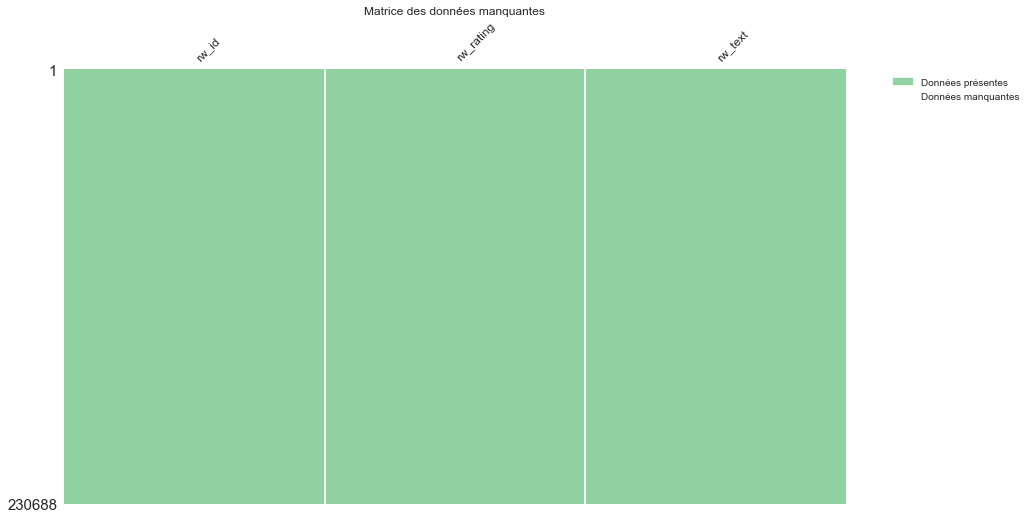

In [30]:
#pk.data_missingTab(reviews)
pk.matrix_vm(reviews, (14,8), (0.564, 0.823, 0.631))

In [13]:
gc.collect()

771

In [31]:
reviews["rw_text"] = reviews["rw_text"].str.lower()

In [32]:
reviews['rw_text'] = reviews.progress_apply(lambda x: convert_emojis(x['rw_text']),axis=1)

C:\Users\aurel\AppData\Local\Temp\ipykernel_20996\653643110.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/230688 [00:00<?, ?it/s]

In [33]:
reviews['rw_text'] = reviews.progress_apply(lambda x: convert_emoticons(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [34]:
gc.collect()

64

In [35]:
reviews['rw_text'] = reviews.progress_apply(lambda x: contractions.fix(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [36]:
gc.collect()

18

In [37]:
reviews['rw_text'] = reviews.progress_apply(lambda x: text_cleaning(x['rw_text'], 0, 1, 0),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [38]:
gc.collect()

18

In [42]:
import dill
dill.dump_session('notebook_env.db')

In [41]:
reviews['words'] = reviews.progress_apply(lambda x: word_tokenize(x['rw_text']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [ ]:
gc.collect()

18

In [5]:
import dill
dill.load_session('notebook_env.db')

In [6]:
reviews['nb_words'] = reviews.progress_apply(lambda x: len(x['words']),axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [9]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                               words  nb_words  
0  [my, favorite, meal, in, paris, we, started, o...        28  
1  [this, is, a, small, barrestaurant, closed, to...        29

In [40]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

KeyboardInterrupt: 

In [ ]:
reviews["nb_words"].describe()

Nous avons en moyenne 101.03 mots par commentaire. Et 50% des commentaires font plus de 72 mots.

Regardons les mots les plus fréquents

In [43]:
words = nltk.tokenize.word_tokenize(" ".join(reviews['rw_text']))

In [51]:
words = nltk.tokenize.word_tokenize(" ".join(reviews['rw_text']))
word_dist = nltk.FreqDist(words)



In [44]:
gc.collect()

18

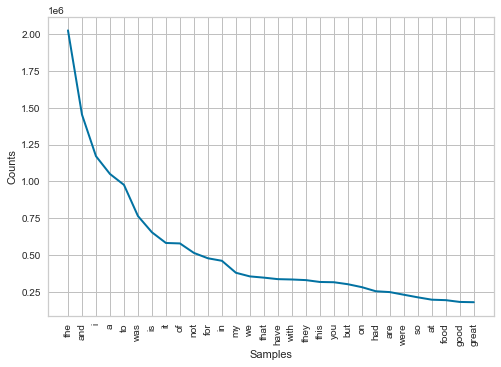

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [53]:
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous observons qu'il y a des déterminants de type : the, in, a qui sont très fréquent.
Nous devons supprimer ces mots car il n'apporte pas d'informations sur le sujet ou le sentiment du commentaire.

Réalisons une fonction pour compter le nombre de mot et faire le graphique

In [44]:
def nb_most_frequent_plt(df_var):
    words = nltk.tokenize.word_tokenize(" ".join(df_var))
    fdist = nltk.FreqDist(words)
    fdist.plot(30)

In [45]:
gc.collect()

18

Essayons d'utiliser la bibliothèque nltk

In [7]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...).
Supprimons ces éléments de la liste de stopwords. De plus, le package supprime certains verbes comme be et have. Nous voulons garder ces verbes pour l'analyse de sentiment.

In [8]:
keep_words = ['not', 'but', 'if', 'because', 'against', 'between', 
              'during', 'before', 'after', 'again', 'more', 'most', 
              'such', 'only', 'own', 'same', 'than', 'too', 'very']
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am'])

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [9]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = reviews['rw_text'].str.replace(pat, '')
reviews['new_words'] = cleaning.progress_apply(lambda x: nltk.word_tokenize(x))
reviews['new_text'] = cleaning



  0%|          | 0/230688 [00:00<?, ?it/s]

In [49]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                               words  nb_words  \
0  [my, favorite, meal, in, paris, we, started, o...        28   
1  [this, is, a, small, barrestaurant, closed, to...        29   

                                           new_words  \
0  [favorite, meal, started, foie, gras, carpacci...   
1  [small, barrestaurant, closed, cathedrale, not...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

In [78]:
gc.collect()

10408

In [ ]:
import dill
dill.load_session('notebook_env_2.db')

Etudions à nouveau les mots les plus fréquents.

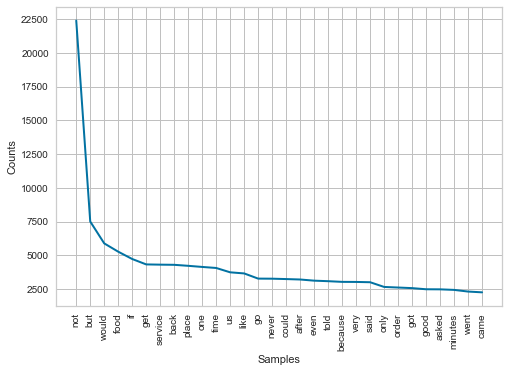

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [77]:
words = nltk.tokenize.word_tokenize(" ".join(reviews["new_text"]))
fdist = nltk.FreqDist(words)
fdist.plot(30)

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [62]:
reviews.head(2)

rw_id  rw_rating  \
0       aGP7nLwEQOUg64jKP8ebsw          5   
1       -to6adg_kucf1SgQckgJXw          5   
2       WMRKQUUR3BmjV_EZg7zVfw          5   
3       un3pGCn6lKHDbaI-hsrk-A          5   
4       3u0PefxOlwysE22VZa9OSA          5   
...                        ...        ...   
400915  bOrQZsNrbd966S4oOq1O5g          5   
400916  kesW3gdryYmHjGfxv_Wx0A          5   
400917  NAwPTlX471lFle06AYt_NA          1   
400918  nyU8UUgC8WbZA1CY2Gqrvw          1   
400919  xYwuu9eRPZiulLgYCXpJ6w          5   

                                                  rw_text  \
0       my favorite meal in paris we started off with ...   
1       this is a small barrestaurant closed to cathed...   
2       this is for a review from  this place is perfe...   
3       when i visited paris last week i had stopped b...   
4       based on some research we decided to book a re...   
...                                                   ...   
400915  stopped in because i love this chain of stores...   
400916  awesome company needed some maintenance on a w...   
400917  i was planning on going into music city golf a...   
400918  i do not recommend this place because they sel...   
400919  back in town for the holidays and needed to fi...   

                                                    words  nb_words  \
0       [my, favorite, meal, in, paris, we, started, o...        28   
1       [this, is, a, small, barrestaurant, closed, to...        29   
2       [this, is, for, a, review, from, this, place, ...        22   
3       [when, i, visited, paris, last, week, i, had, ...        29   
4       [based, on, some, research, we, decided, to, b...        27   
...                                                   ...       ...   
400915  [stopped, in, because, i, love, this, chain, o...       137   
400916  [awesome, company, needed, some, maintenance, ...        77   
400917  [i, was, planning, on, going, into, music, cit...       211   
400918  [i, do, not, recommend, this, place, because, ...        88   
400919  [back, in, town, for, the, holidays, and, need...        64   

                                                new_words  \
0       [favorite, meal, started, foie, gras, carpacci...   
1       [small, barrestaurant, closed, cathedrale, not...   
2       [review, place, perfect, would, recommend, pri...   
3       [visited, last, week, stopped, recommendation,...   
4       [based, research, decided, book, reservation, ...   
...                                                   ...   
400915  [stopped, because, love, chain, stores, stop, ...   
400916  [awesome, company, needed, maintenance, water,...   
400917  [planning, going, music, city, golf, buying, n...   
400918  [not, recommend, place, because, sell, fake, t...   
400919  [back, town, holidays, needed, find, new, plac...   

                                                 new_text  
0        favorite meal    started    foie gras carpacc...  
1          small barrestaurant closed  cathedrale notr...  
2           review    place  perfect would recommend  ...  
3         visited  last week   stopped     recommendat...  
4       based   research  decided  book  reservation  ...  
...                                                   ...  
400915  stopped  because  love  chain  stores  stop   ...  
400916  awesome company needed  maintenance   water he...  
400917    planning  going  music city golf  buying  ne...  
400918    not recommend  place because  sell fake thin...  
400919  back  town   holidays  needed  find  new place...  

[401120 rows x 7 columns]

Nous pouvons supprimer les colonnes inutiles

In [11]:
del reviews["nb_words"]

In [12]:
reviews = reviews.drop(["new_words", "words"], axis=1)

In [54]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

Ajoutons des tags pour connaitre la nature de chaque mot.

In [13]:
gc.collect()

17

In [14]:
def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

In [ ]:
reviews.shape

In [15]:
all_reviews = reviews["new_text"].str.cat(sep=' ')

In [5]:
all_reviews.head(2)

NameError: name 'all_reviews' is not defined

In [16]:
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [636]:
description_words

[('favorite', 'JJ'),
 ('meal', 'NN'),
 ('started', 'VBD'),
 ('foie', 'JJ'),
 ('gras', 'NNS'),
 ('carpaccio', 'VBP'),
 ('escargot', 'RB'),
 ('love', 'VB'),
 ('unique', 'JJ'),
 ('way', 'NN'),
 ('foie', 'NN'),
 ('gras', 'NN'),
 ('was', 'VBD'),
 ('prepared', 'VBN'),
 ('thinly', 'RB'),
 ('is', 'VBZ'),
 ('small', 'JJ'),
 ('barrestaurant', 'NN'),
 ('closed', 'VBD'),
 ('cathdrale', 'NN'),
 ('notre', 'NN'),
 ('dame', 'NN'),
 ('always', 'RB'),
 ('come', 'VBN'),
 ('lunch', 'NN'),
 ('dinner', 'NN'),
 ('if', 'IN'),
 ('close', 'JJ'),
 ('hostess', 'NN'),
 ('is', 'VBZ'),
 ('very', 'RB'),
 ('friendly', 'JJ'),
 ('is', 'VBZ'),
 ('review', 'JJ'),
 ('place', 'NN'),
 ('is', 'VBZ'),
 ('perfect', 'JJ'),
 ('would', 'MD'),
 ('recommend', 'VB'),
 ('prices', 'NNS'),
 ('are', 'VBP'),
 ('great', 'JJ'),
 ('food', 'NN'),
 ('is', 'VBZ'),
 ('astoundingand', 'RB'),
 ('never', 'RB'),
 ('leave', 'VBP'),
 ('reviews', 'NNS'),
 ('michelin', 'NNS'),
 ('starred', 'VBD'),
 ('reservations', 'NNS'),
 ('weeks', 'NNS'),
 ('advance'

In [57]:
tag_fd = nltk.FreqDist(tag for (word, tag) in description_words)

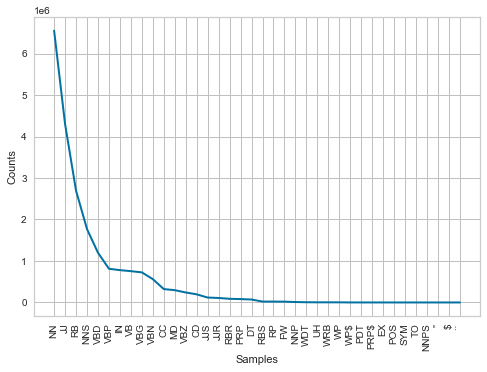

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [58]:
tag_fd.plot()

UH = interjection (expression affective > ha, oh)
EX = existentiel (ex : il y a)
WDT = wh-déterminant (ex : qui)
pour plus d'informations, voir : https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/

On exclut : IN, DT, CD, CC, RP, WDT, EX, MD, NNP, WDT, UH, WRB, 
WP, WP$, PDT, PRP$, EX, POS, SYM, TO, NNPS


In [640]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw        5.0   
1  -to6adg_kucf1SgQckgJXw        5.0   

                                                                                               rw_text  \
0  my favorite meal in paris we started off with the foie gras carpaccio and escargot love the uniq...   
1  this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or din...   

                                                                                              new_text  \
0   favorite meal    started    foie gras carpaccio  escargot love  unique way   foie gras was prep...   
1   is  small barrestaurant closed  cathdrale notre dame  always come   lunch  dinner if   close   ...   

                                                                                               stemmed  \
0             favorit meal start foie gras carpaccio escargot love uniqu way foie gras was prepar thin   
1  is small barrestaur close cathdral notr dame alway come lunch dinner if close hostess is veri fr...   

                                                                                            lemmatized  
0      favorite meal started foie gras carpaccio escargot love unique way foie gras wa prepared thinly  
1  is small barrestaurant closed cathdrale notre dame always come lunch dinner if close hostess is ...

In [17]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX', 'MD', 'NNP', 'WDT', 'UH', 'WRB', 
'WP', 'WP$', 'PDT', 'PRP$', 'EX', 'POS', 'SYM', 'TO', 'NNPS']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

In [ ]:
gc.collect()

1650

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  
0   favorite meal    started    foie gras carpacc...  
1     small barrestaurant closed  cathedrale notr...

In [18]:
import dill
dill.dump_session('notebook_env.db')

In [19]:
reviews["text_tokens_pos_tagged"] =  reviews["new_text"].progress_apply(lambda x: nltk.word_tokenize(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [20]:
gc.collect()

18

In [21]:
reviews["text_tokens_pos_tagged"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: nltk.pos_tag(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [22]:
gc.collect()

34

In [23]:
list_keep = set(list_keep)

In [24]:
list_keep = list(list_keep)

In [25]:
reviews["text_tagged_nn_vb"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_keep])

  0%|          | 0/230688 [00:00<?, ?it/s]

In [26]:
list_nouns = ["NN", "NNS"]

reviews["words_subjects"] =  reviews["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_nouns])


  0%|          | 0/230688 [00:00<?, ?it/s]

In [27]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  [favorite, meal, started, foie, gras, carpacci...   
1  [small, barrestaurant, closed, cathedrale, not...   

                                      words_subjects  
0                            [meal, gras, way, gras]  
1  [barrestaurant, cathedrale, notre, dame, lunch...

In [28]:
reviews["words_subjects"] =  reviews["words_subjects"].progress_apply(lambda x: " ".join(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [29]:
reviews["text_tagged_nn_vb"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: " ".join(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

Concernant le traitement des sujets d'insatisfaction, il serait aussi intéressant de conserver la racine des mots après avoir filtrer sur les noms.
Il existe deux méthodes : Stemming et lemmatization.
Stemming supprime les suffixes et les préfixes des mots sans prendre en considération le contexte. 
Contrairement à la méthode stemming, la méthode lemmatization considère le contexte et convertit le mot dans sa forme de base "significative".

In [30]:
def stemming_text(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [31]:
stemming_text("running")

'run'

In [32]:
lemmatize_text("runs")

'run'

In [34]:
reviews.shape

(230688, 7)

In [35]:
def short_words(text, lem_stem, new_var, var_to_convert):
    if lem_stem == 1: 
        stemmer = SnowballStemmer(language='english')
        reviews[new_var] = reviews[var_to_convert].progress_apply(lambda x: " ".join([stemmer.stem(y) for y in x]))
    if lem_stem == 2:
        reviews[new_var] = reviews[var_to_convert].progress_apply(lambda x: " ".join([lemmatize_text(y) for y in x]))


In [36]:
gc.collect()

7

In [37]:
reviews["words_subjects_st"] = reviews["words_subjects"].progress_apply(lambda x: stemming_text(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [38]:
reviews["words_subjects_lem"] = reviews["words_subjects"].progress_apply(lambda x: lemmatize_text(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [39]:
reviews["text_tagged_nn_vb_st"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: stemming_text(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [40]:
reviews["text_tagged_nn_vb_lem"] =  reviews["text_tagged_nn_vb"].progress_apply(lambda x: lemmatize_text(x))


  0%|          | 0/230688 [00:00<?, ?it/s]

In [41]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                     words_subjects  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  
0  favorite meal started foie gras carpaccio esca...  
1  small barrestaurant closed cathedrale notre da...

Regardons les mots les plus fréquents pour chaque méthode

In [6]:
gc.collect()

561

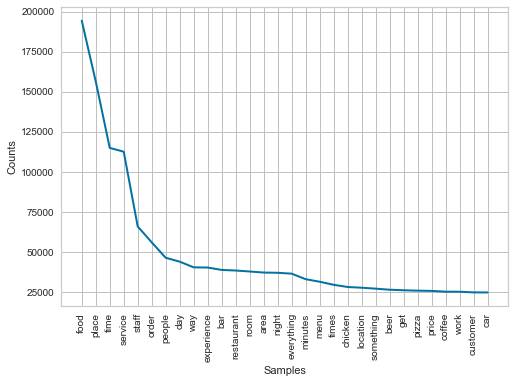

In [116]:
nb_most_frequent_plt(reviews["words_subjects_st"])

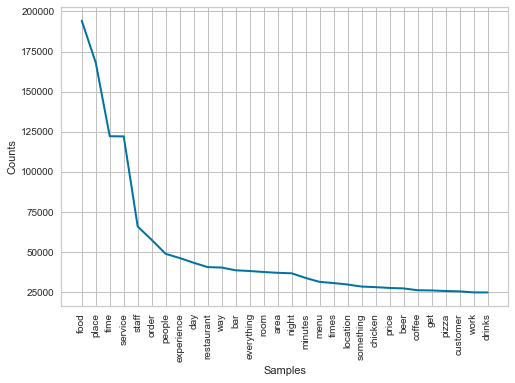

In [117]:
nb_most_frequent_plt(reviews["words_subjects_lem"])

Nous utilisons Vader pour obtenir les impressions de sentiments des couples de mots(positif, neutre, negatif).

Créons une fonction pour obtenir des informations sur les sentiments des groupes de mots.

In [43]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [44]:
reviews["text_nn_vb_lem_feels"] = reviews["text_tagged_nn_vb_lem"].progress_apply(lambda x: sentiment_scores(x))

  0%|          | 0/230688 [00:00<?, ?it/s]

In [45]:
import dill
dill.dump_session('notebook_env_2.db')

In [244]:
reviews.shape

(50875, 3)

In [8]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                              text_tokens_pos_tagged  \
0  [(favorite, JJ), (meal, NN), (started, VBD), (...   
1  [(small, JJ), (barrestaurant, NN), (closed, VB...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                     words_subjects  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  
0  {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...  
1  {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...

In [46]:
gc.collect()

0

In [9]:
del reviews["text_tokens_pos_tagged"]

In [10]:
gc.collect()

0

In [11]:
reviews['text_nn_vb_lem_feels'].head(5)

0    {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...
1    {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...
2    {'neg': 0.0, 'neu': 0.379, 'pos': 0.621, 'comp...
3    {'neg': 0.102, 'neu': 0.428, 'pos': 0.471, 'co...
4    {'neg': 0.0, 'neu': 0.78, 'pos': 0.22, 'compou...
Name: text_nn_vb_lem_feels, dtype: object

In [12]:
reviews = pd.concat([reviews, 
    reviews['text_nn_vb_lem_feels'].apply(pd.Series)]
    , axis=1)


In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                               text_tagged_nn_vb_lem  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  neg    neu    pos  \
0  {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...  0.0  0.547  0.453   
1  {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...  0.0  0.788  0.212   

   compound  
0    0.8442  
1    0.5413

In [13]:
reviews.columns = ['rw_id',	'rw_rating', 'rw_text', 'new_text', 'text_tagged_nn_vb', 
                    'words_subjects', 'words_subjects_st', 'words_subjects_lem', 'text_tagged_nn_vb_st',
                    'text_nn_vb_lem_feels', 'text_tagged_nn_vb_lem', 'feeling_neg', 'feeling_neu', 'feeling_pos', 'feeling_compound']

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  favorite meal started foie gras carpaccio esca...          0.0   
1  small barrestaurant closed cathedrale notre da...          0.0   

   feeling_neu  feeling_pos  feeling_compound  
0        0.547        0.453            0.8442  
1        0.788        0.212            0.5413

In [14]:
del reviews["text_tagged_nn_vb_lem"]

In [15]:
gc.collect()

0

In [16]:
def feeling_avg(compound, pos, neg):
    # decide sentiment as positive, negative and neutral
    if compound >= 0.6 and pos>0.5 :
        feeling_avg = "Positive"
    elif compound <= - 0.5  and neg > 0.3 :
        feeling_avg = "Negative"
    else :
        feeling_avg = "Neutral"
    return feeling_avg


In [17]:
reviews["feeling_avg"] = reviews.progress_apply(lambda x: feeling_avg(x["feeling_compound"], x["feeling_pos"], x["feeling_neg"]), axis=1)

  0%|          | 0/230688 [00:00<?, ?it/s]

In [ ]:
reviews.head(2)

rw_id  rw_rating  \
0  aGP7nLwEQOUg64jKP8ebsw          5   
1  -to6adg_kucf1SgQckgJXw          5   

                                             rw_text  \
0  my favorite meal in paris we started off with ...   
1  this is a small barrestaurant closed to cathed...   

                                            new_text  \
0   favorite meal    started    foie gras carpacc...   
1     small barrestaurant closed  cathedrale notr...   

                                   text_tagged_nn_vb  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                      words_subjects  \
0                            [meal, gras, way, gras]   
1  [barrestaurant, cathedrale, notre, dame, lunch...   

                                words_subjects_st  \
0                               meal gras way gra   
1  barrestaurant cathedrale notre dame lunch dinn   

                                 words_subjects_lem  \
0                                meal gras way gras   
1  barrestaurant cathedrale notre dame lunch dinner   

                                text_tagged_nn_vb_st  \
0  favorite meal started foie gras carpaccio esca...   
1  small barrestaurant closed cathedrale notre da...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  favorite meal started foie gras carpaccio esca...          0.0   
1  small barrestaurant closed cathedrale notre da...          0.0   

   feeling_neu  feeling_pos  feeling_compound feeling_avg  
0        0.547        0.453            0.8442     Neutral  
1        0.788        0.212            0.5413     Neutral

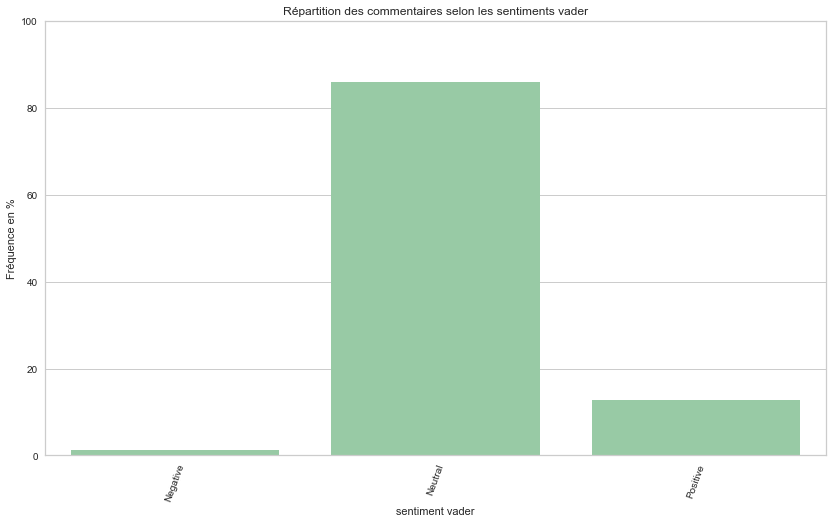

In [55]:
pk.graph_barplot(reviews['feeling_avg'],
                  "Répartition des commentaires selon les sentiments vader",
                  (0.564, 0.823, 0.631),
                   0, 100, "sentiment vader", "Fréquence en %",70, 1, (14,8))

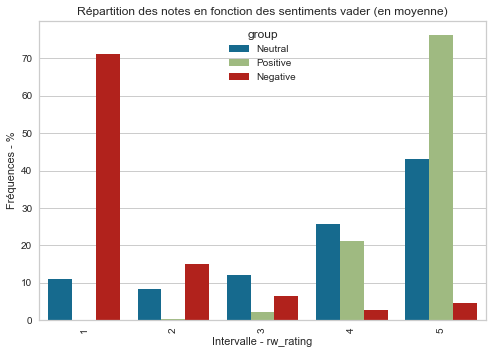

In [56]:
pk.graph_barplot_by_group(reviews, 'rw_rating', 'feeling_avg', '#6D8260', 'Répartition des notes en fonction des sentiments vader (en moyenne)')


In [ ]:
for i in reviews.loc[reviews["feeling_avg"]=='Negative']["rw_text"].head(10):
    print(i)

michelin one thing ill always carry with me when i think back on my trip to paris was not only the food because its amazing but the smell of the
while this was not the best meal i had in paris it was probably the best service i received the cobb salad was visually if not delectably special the
admittedly my review is  years late i was last in paris in spring  my mother had died the week before i stumbled on this place by accident the
terrible service we got inside and sat down and no waiter approached in  minutes the waiter acted like we were a burden to her just for setting the


In [ ]:
for idx, i in reviews.loc[reviews["rw_rating"]==5].head(10).iterrows():
    print(i["rw_text"], " ", str(i["compound"]))

my favorite meal in paris we started off with the foie gras carpaccio and escargot love the unique way that the foie gras was prepared and so thinly   0.8442
this is a small barrestaurant closed to cathdrale notre dame i always come here for lunch or dinner if i am close by the hostess is very friendly the   0.5413
this is for a review from  this place is perfect would recommend  prices are great food is astoundingand i never leave reviews   0.8872
michelin starred reservations weeks in advance is absolutely necessary to dine at an establishment like this my second time here very sophisticated vibe   0.5984
when i visited paris last week i had stopped by here by a recommendation of a friend and also recommended by bourdain this place was amazing and lives up   0.7845
based on some research we decided to book a reservation here for a meal on our first night in paris with our friends  families   kids  adults it   0.4767
if you know you know hands down my absolute favorite restaurant in p

Nous conservons les reviews inférieur ou égal à 1.

In [241]:
reviews_sav = reviews.copy()

In [247]:
reviews = reviews_sav.loc[reviews_sav["rw_rating"]<=1].head(2000).copy()

In [248]:
reviews.describe()

rw_rating
count     2000.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0

In [20]:
import dill
dill.dump_session('notebook_env.db')

In [11]:
import dill
dill.load_session('notebook_env.db')

FileNotFoundError: [Errno 2] No such file or directory: 'notebook_env.db'

Regardons les sujets qui ressortent à l'aide d'un graphique word cloud

In [14]:
from wordcloud import WordCloud
from PIL import Image

In [61]:
gc.collect()

7737

In [63]:
reviews.head(2)

rw_id  rw_rating  \
111  wejeLM6zS_qWL6U4rU0okg          1   
9    BkdgkKU1uvUW0-LhfS2JVw          1   

                                               rw_text  \
111  service was super nice and friendly we are her...   
9    the food better be good because the iced coffe...   

                                              new_text  \
111  service  super nice  friendly     dinner one n...   
9     food better  good because  iced coffee  horri...   

                                     text_tagged_nn_vb  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                        words_subjects  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                     words_subjects_st  \
111               service dinner night place food pric   
9    food coffee service deplorableparty minutes mi...   

                                    words_subjects_lem  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                  text_tagged_nn_vb_st  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                  text_nn_vb_lem_feels  feeling_neg  \
111  service super nice friendly dinner night reall...        0.096   
9    food better good iced coffee horrible service ...        0.085   

     feeling_neu  feeling_pos  feeling_compound feeling_avg  
111        0.399        0.505            0.8826    Positive  
9          0.633        0.282            0.7964     Neutral

In [65]:
all_reviews = " ".join(reviews["words_subjects"])

In [67]:
reviews.shape

(23985, 15)

In [68]:
all_reviews = " ".join(reviews["words_subjects"])

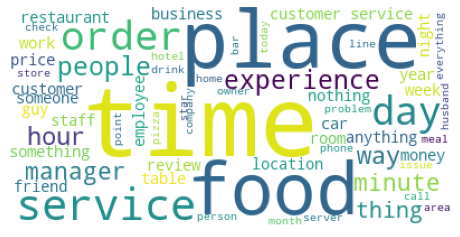

In [69]:
wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Nous remarquons que les sujets principaux sont le repas, le service, le restaurant, la localisation et le menu.

In [22]:
def wordcloud_plot(data):
    all_reviews = data.str.cat(sep=' ')
    wordcloud = WordCloud(background_color = 'white', max_words = 60).generate(all_reviews)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [203]:
reviews.columns

Index(['rw_id', 'rw_rating', 'rw_text', 'new_text', 'text_tagged_nn_vb',
       'words_subjects', 'words_subjects_st', 'words_subjects_lem',
       'text_tagged_nn_vb_st', 'text_nn_vb_lem_feels', 'feeling_neg',
       'feeling_neu', 'feeling_pos', 'feeling_compound', 'feeling_avg'],
      dtype='object')

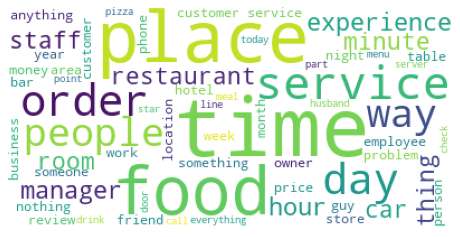

In [71]:
wordcloud_plot(reviews["words_subjects_st"])

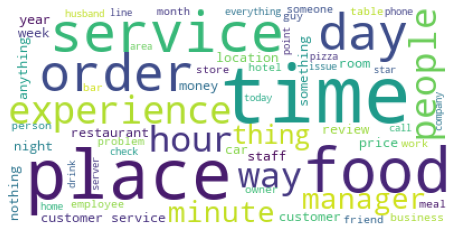

In [72]:
wordcloud_plot(reviews["words_subjects_lem"])

La colonne words_subjects semble donner de meilleurs résultats

## Features : deux méthodes BOW & TF-IDF

### Bags of words (BOW)

L’approche bags of words consiste à compter les occurences de chaque mot dans chaque document de la base de données.

In [8]:
reviews.head(2)

rw_id  rw_rating  \
111  wejeLM6zS_qWL6U4rU0okg          1   
9    BkdgkKU1uvUW0-LhfS2JVw          1   

                                               rw_text  \
111  service was super nice and friendly we are her...   
9    the food better be good because the iced coffe...   

                                              new_text  \
111  service  super nice  friendly     dinner one n...   
9     food better  good because  iced coffee  horri...   

                                     text_tagged_nn_vb  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                        words_subjects  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                     words_subjects_st  \
111               service dinner night place food pric   
9    food coffee service deplorableparty minutes mi...   

                                    words_subjects_lem  \
111             service dinner night place food prices   
9    food coffee service deplorableparty minutes mi...   

                                  text_tagged_nn_vb_st  \
111  service super nice friendly dinner night reall...   
9    food better good iced coffee horrible service ...   

                                  text_nn_vb_lem_feels  feeling_neg  \
111  service super nice friendly dinner night reall...        0.096   
9    food better good iced coffee horrible service ...        0.085   

     feeling_neu  feeling_pos  feeling_compound feeling_avg  
111        0.399        0.505            0.8826    Positive  
9          0.633        0.282            0.7964     Neutral

In [13]:
reviews.shape

(5000, 15)

In [23]:
reviews_compl = reviews.copy()

In [13]:
reviews_compl.shape

(23985, 15)

In [14]:
reviews = reviews_compl.sample(6000)

In [15]:
reviews = reviews.reset_index()

In [16]:
from  sklearn.feature_extraction.text  import CountVectorizer 
# créer un vecteur d'objet 
vectorizer = CountVectorizer()
corpus = reviews["words_subjects_lem"]


In [14]:
gc.collect()

0

In [18]:
# apprendre le vocabulaire et stocker la matrice creuse CountVectorizer dans X 
cbow = vectorizer.fit_transform(corpus).todense()
new_cols = vectorizer.get_feature_names()

In [19]:
reviews.head(2)

index                   rw_id  rw_rating  \
0   34859  EaSJOc9zoW8FvlrZ3JAq0Q          1   
1  140331  PrG8ohauxUI4N8_clQAo0A          1   

                                             rw_text  \
0  horrible experience we made reservations in ad...   
1  worst experience in a restaurant ever food was...   

                                            new_text  \
0  horrible experience  made reservations  advanc...   
1  worst experience   restaurant ever food  broug...   

                                   text_tagged_nn_vb  \
0  horrible experience made reservations advance ...   
1  worst experience restaurant ever food brought ...   

                                      words_subjects  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                   words_subjects_st  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                  words_subjects_lem  \
0  experience reservations advance table party ma...   
1  experience restaurant food minutes owner fishy...   

                                text_tagged_nn_vb_st  \
0  horrible experience made reservations advance ...   
1  worst experience restaurant ever food brought ...   

                                text_nn_vb_lem_feels  feeling_neg  \
0  horrible experience made reservations advance ...        0.131   
1  worst experience restaurant ever food brought ...        0.169   

   feeling_neu  feeling_pos  feeling_compound feeling_avg  
0        0.766        0.104           -0.5318     Neutral  
1        0.695        0.136           -0.4585     Neutral

In [29]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(pd.DataFrame(cbow, columns=new_cols),rsuffix="_left")

In [21]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles  zoom  zoos  \
0  boyfriend went got free mvp coupon mail not on...  ...       0     0     0   
1  rude very unprofessional never such horrible e...  ...       0     0     0   

   zorbas  zucchini zupas  zuppa  zuppas  zydeco  zydecos  
0       0         0     0      0       0       0        0  
1       0         0     0      0       0       0        0  

[2 rows x 23070 columns]

### TF-IDF

Cette méthode permet de mieux définir l'importance d'un mot pour un document, tout en prenant en compte la relation avec les autres documents du même corpus.
Nous allons calculer un score à chaque mot de chaque document de notre ensemble de données. Et pour chaque mot, la valeur TF-IDF augmente à chaque apparition du mot dans un document, mais diminue progressivement à chaque apparition dans d'autres documents.

In [15]:
gc.collect()

0

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(reviews["words_subjects_lem"]).todense()
new_cols = vectorizer.get_feature_names()


In [32]:
tfidf_df = pd.DataFrame(tfIdf, columns=new_cols)

In [33]:
tfidf_df.head(2)

aaa  aaand  aand  aaron  aarrrgghhh  aback  abacus  abalone  abandon  \
0  0.0    0.0   0.0    0.0         0.0    0.0     0.0      0.0      0.0   
1  0.0    0.0   0.0    0.0         0.0    0.0     0.0      0.0      0.0   

   abbreviate  ...  zoneblind  zoo  zoom  zorbas  zucchini  zuppa  zwei  \
0         0.0  ...        0.0  0.0   0.0     0.0       0.0    0.0   0.0   
1         0.0  ...        0.0  0.0   0.0     0.0       0.0    0.0   0.0   

   zydeco  zydecos  zzzzzzzx  
0     0.0      0.0       0.0  
1     0.0      0.0       0.0  

[2 rows x 18401 columns]

In [26]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles  zoom  zoos  \
0  boyfriend went got free mvp coupon mail not on...  ...       0     0     0   
1  rude very unprofessional never such horrible e...  ...       0     0     0   

   zorbas  zucchini zupas  zuppa  zuppas  zydeco  zydecos  
0       0         0     0      0       0       0        0  
1       0         0     0      0       0       0        0  

[2 rows x 23070 columns]

In [34]:
# join the tfidf values to the existing dataframe
reviews = reviews.join(tfidf_df, rsuffix='_tfidf')

In [28]:
reviews.head(2)

index                   rw_id  rw_rating  \
0  209851  AactXP4rMr0jhK2Vyd1g2g          1   
1  196296  gBEBLNlY3AjBExSJHwWgUg          1   

                                             rw_text  \
0  my boyfriend just went in because we got a fre...   
1  rude and very unprofessional  i have never had...   

                                            new_text  \
0   boyfriend  went  because  got  free mvp coupo...   
1  rude  very unprofessional    never  such  horr...   

                                   text_tagged_nn_vb  \
0  boyfriend went got free mvp coupon mail not on...   
1  rude very unprofessional never such horrible e...   

                      words_subjects               words_subjects_st  \
0  mvp coupon mail cowlick hair rate  mvp coupon mail cowlick hair r   
1                   experience money                experience money   

                  words_subjects_lem  \
0  mvp coupon mail cowlick hair rate   
1                   experience money   

                                text_tagged_nn_vb_st  ... zoodles_tfidf  \
0  boyfriend went got free mvp coupon mail not on...  ...           0.0   
1  rude very unprofessional never such horrible e...  ...           0.0   

   zoom_tfidf  zoos_tfidf  zorbas_tfidf  zucchini_tfidf zupas_tfidf  \
0         0.0         0.0           0.0             0.0         0.0   
1         0.0         0.0           0.0             0.0         0.0   

   zuppa_tfidf  zuppas_tfidf  zydeco_tfidf  zydecos_tfidf  
0          0.0           0.0           0.0            0.0  
1          0.0           0.0           0.0            0.0  

[2 rows x 46124 columns]

Maintenant que nous avons ajouté nos features, nous pouvons réaliser une PCA afin de voir quelles sont les variables qui expliquent au mieux nos données.

# Analyse multidimensionnelle : ACP / T-SNE / UMAP

ajouts infos des methodes

In [79]:
import dill
dill.dump_session('notebook_env_2.db')

In [75]:
import dill
dill.load_session('notebook_env_2.db')

In [81]:
reviews.shape

(10000, 36818)

In [82]:
reviews_sav = reviews.copy()

In [83]:
gc.collect()

7

In [84]:
reviews['rw_rating'].unique()

array([1], dtype=int64)

In [85]:
reviews = reviews_sav.sample(3000)

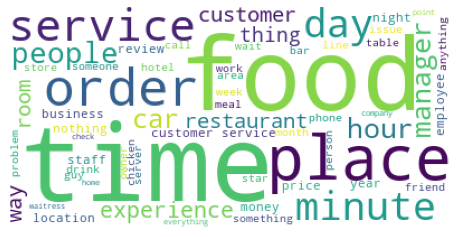

In [86]:
wordcloud_plot(reviews["words_subjects_lem"])

In [10]:
del reviews["index"]

In [88]:
df_acp = reviews.copy()


In [89]:
df_acp.head(2)

index                   rw_id  rw_rating  \
5731   17402  dxAwZpHEx2lY3lbimsHifw          1   
3022  200308  6pquxsYDZXxtA_19MiKMQg          1   

                                                rw_text  \
5731  why the heck is this place popular  my only gu...   
3022  checked in online and when i arrived i still w...   

                                               new_text  \
5731    heck   place popular   only guess    people ...   
3022  checked  online    arrived  still waited  minu...   

                                      text_tagged_nn_vb  \
5731  heck place popular only guess people new new o...   
3022  checked online arrived still waited minutes th...   

                                         words_subjects  \
5731  heck place people orleans experience lot line ...   
3022        online minutes time start place haicutlooks   

                                      words_subjects_st  \
5731  heck place people orleans experience lot line ...   
3022         online minutes time start place haicutlook   

                                     words_subjects_lem  \
5731  heck place people orleans experience lot line ...   
3022        online minutes time start place haicutlooks   

                                   text_tagged_nn_vb_st  ... zoneblind_tfidf  \
5731  heck place popular only guess people new new o...  ...             0.0   
3022  checked online arrived still waited minutes th...  ...             0.0   

      zoo_tfidf  zoom_tfidf  zorbas_tfidf  zucchini_tfidf zuppa_tfidf  \
5731        0.0         0.0           0.0             0.0         0.0   
3022        0.0         0.0           0.0             0.0         0.0   

      zwei_tfidf  zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  
5731         0.0           0.0            0.0             0.0  
3022         0.0           0.0            0.0             0.0  

[2 rows x 36818 columns]

In [12]:
gc.collect()

830

In [90]:
df_acp2 = df_acp.drop(["rw_id", "rw_rating", "rw_text", "new_text", "text_tagged_nn_vb", "words_subjects", "words_subjects_st", "words_subjects_lem", "text_tagged_nn_vb_st"], axis=1)

In [91]:
del df_acp2["text_nn_vb_lem_feels"]

In [92]:
del df_acp2["feeling_avg"]

In [93]:
df_acp2.head(2) #####ici

index  feeling_neg  feeling_neu  feeling_pos  feeling_compound  aaa  \
5731   17402         0.08        0.633        0.287            0.9667    0   
3022  200308         0.00        1.000        0.000            0.0000    0   

      aaand  aand  aaron  aarrrgghhh  ...  zoneblind_tfidf  zoo_tfidf  \
5731      0     0      0           0  ...              0.0        0.0   
3022      0     0      0           0  ...              0.0        0.0   

      zoom_tfidf  zorbas_tfidf  zucchini_tfidf  zuppa_tfidf  zwei_tfidf  \
5731         0.0           0.0             0.0          0.0         0.0   
3022         0.0           0.0             0.0          0.0         0.0   

      zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  
5731           0.0            0.0             0.0  
3022           0.0            0.0             0.0  

[2 rows x 36807 columns]

### ACP

In [17]:
gc.collect()

0

3000
[1.23783350e+02 6.41760381e+01 5.78125517e+01 ... 2.92258828e-29
 2.24491619e-29 1.44856539e-29]
[6.59852230e-03 3.42103376e-03 3.08181522e-03 ... 1.55794491e-33
 1.19669807e-33 7.72187136e-34]
     Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0         Dim1     1.237421e+02                   1.0                    1.0
1         Dim2     6.415465e+01                   0.0                    1.0
2         Dim3     5.779328e+01                   0.0                    1.0
3         Dim4     5.724892e+01                   0.0                    2.0
4         Dim5     5.419096e+01                   0.0                    2.0
...        ...              ...                   ...                    ...
2995   Dim2996     6.812146e-03                   0.0                  100.0
2996   Dim2997     6.463800e-06                   0.0                  100.0
2997   Dim2998     2.921614e-29                   0.0                  100.0
2998   Dim2999     2.244168e-29

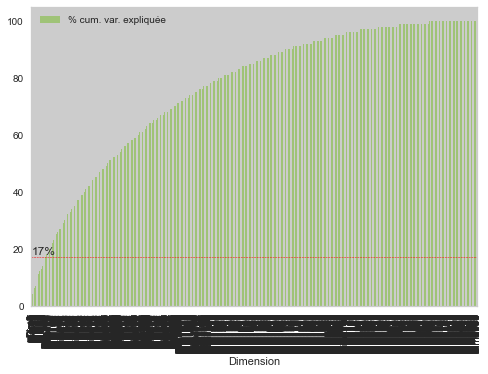

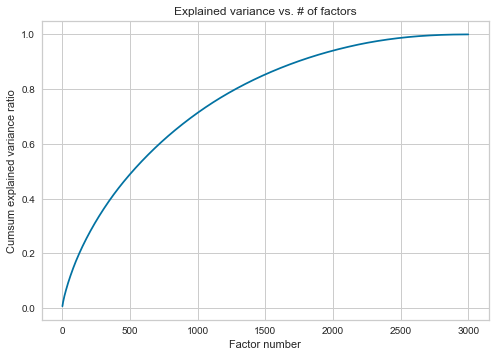

In [92]:
Z = pk_multi.amulti_acp_standard(df_acp2)
pk_multi.amulti_acp_choice_dim(df_acp2, Z)

Il faudrait 1000 dimensions pour obtenir 80% de la variance expliquée.

In [93]:
import numpy as np
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA


In [94]:
transformer = SparsePCA(n_components=12, random_state=0)
transformer.fit(df_acp2)

X_transformed = transformer.transform(df_acp2)
X_transformed.shape

# most values in the components_ are zero (sparsity)
np.mean(transformer.components_ == 0)

0.9988136314650293

In [95]:
X_transformed.shape

(3000, 12)

[Text(0.5, 1.0, 'Data SparsePCA projection')]

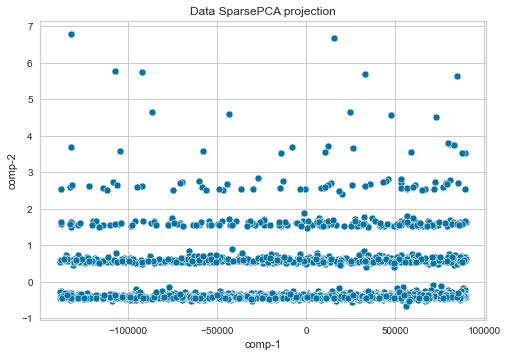

In [96]:
df_sparseacp = pd.DataFrame()
df_sparseacp["comp-1"] = X_transformed[:,0]
df_sparseacp["comp-2"] = X_transformed[:,1]

sns.scatterplot(x="comp-1", y="comp-2", #hue=df_sparseacp.y.tolist(),
                #palette=sns.color_palette("hls", 3),
                data=df_sparseacp).set(title="Data SparsePCA projection") 

In [120]:
Z = pk_multi.amulti_acp_standard(X_transformed)

12
[2.15594735 1.31259365 1.18619349 1.0091377  0.98179302 0.9555634
 0.87892438 0.80834246 0.74171015 0.73209901 0.67937134 0.56232539]
[0.17960239 0.10934634 0.09881651 0.08406678 0.08178881 0.07960374
 0.07321928 0.06733942 0.06178858 0.06098791 0.05659541 0.04684483]
   Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0       Dim1         2.155229                  18.0                   18.0
1       Dim2         1.312156                  11.0                   29.0
2       Dim3         1.185798                  10.0                   39.0
3       Dim4         1.008801                   8.0                   47.0
4       Dim5         0.981466                   8.0                   55.0
5       Dim6         0.955245                   8.0                   63.0
6       Dim7         0.878631                   7.0                   71.0
7       Dim8         0.808073                   7.0                   77.0
8       Dim9         0.741463                   6.0  

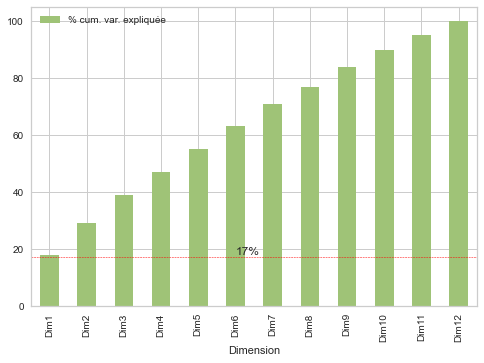

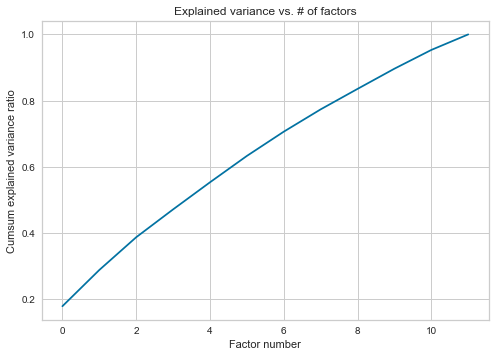

In [121]:
pk_multi.amulti_acp_choice_dim(X_transformed, Z)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


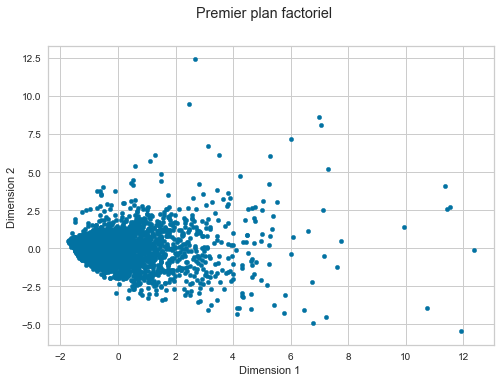

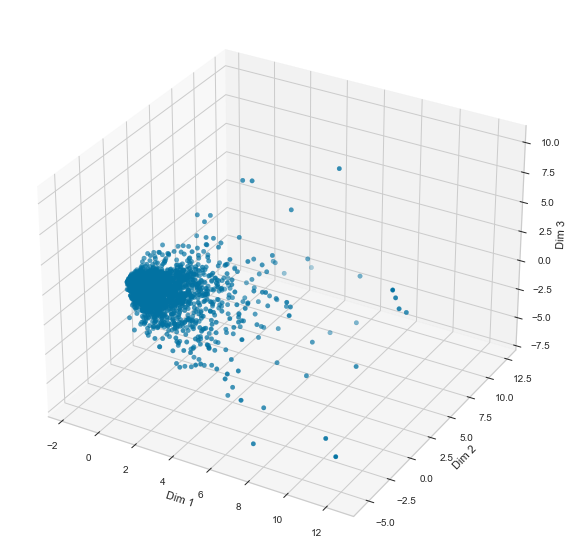

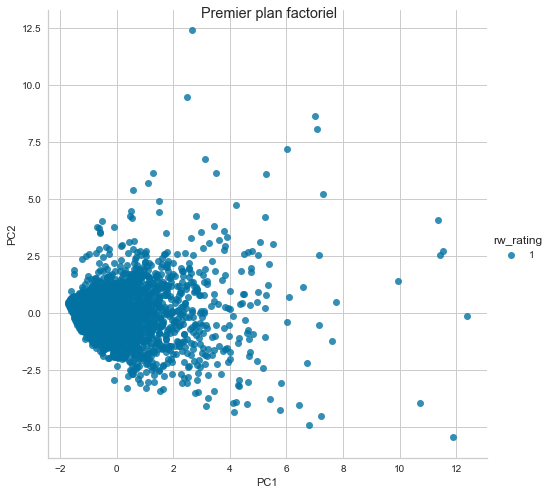

TypeError: unsupported operand type(s) for -: 'range' and 'int'

In [122]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(X_transformed, Z, 3, df_acp, df_acp["words_subjects"], reviews["rw_rating"], "rw_rating", 0)

Il faudrait 11 dimansions pour obtenir 80% de la variance expliquée.

### T-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.187s...
[t-SNE] Computed neighbors for 3000 samples in 3.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 831.740396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.102463
[t-SNE] KL divergence after 300 iterations: 0.645189


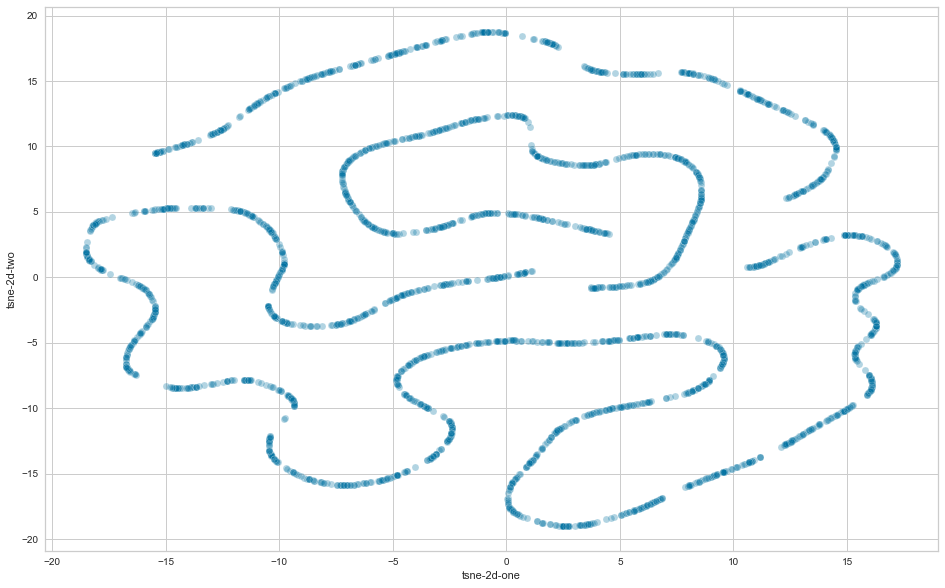

In [ ]:
pk_multi.tsne_graph(df_acp2, group=0, by="")

### UMAP

In [ ]:
pk_multi.umap_graphs(df_acp2)

# Modèle : LDA / K-means / Bert

In [ ]:
gc.collect()

499170

In [ ]:
reviews.head(2)

index                   rw_id  rw_rating  \
1539  159563  x1rvgtOrZ4eWD0Woe_sFXg          1   
2522  125996  hcPJlMB2PnYbNP8KnqzKhA          1   

                                                                                                  rw_text  \
1539  this is by far the worst dealership i have ever dealt with i had a volkswagen rabbit that had a ...   
2522  i am an executive elite member and use national car rental all across the country  this was by f...   

                                                                                                 new_text  \
1539     far  worst dealership   ever dealt     volkswagen rabbit    leak   roof  water  coming   car ...   
2522     executive elite member  use national car rental  across  country     far  worst rental vehicl...   

                                                                                        text_tagged_nn_vb  \
1539  far worst dealership ever dealt volkswagen rabbit leak roof water coming car time rained took we...   
2522  executive elite member use national car rental country far worst rental vehicle ever driven car ...   

                                                                                           words_subjects  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                        words_subjects_st  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                       words_subjects_lem  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                     text_tagged_nn_vb_st  \
1539  far worst dealership ever dealt volkswagen rabbit leak roof water coming car time rained took we...   
2522  executive elite member use national car rental country far worst rental vehicle ever driven car ...   

      ... zoneblind_tfidf  zoo_tfidf  zoom_tfidf  zorbas_tfidf  \
1539  ...             0.0        0.0         0.0           0.0   
2522  ...             0.0        0.0         0.0           0.0   

      zucchini_tfidf zuppa_tfidf  zwei_tfidf  zydeco_tfidf  zydecos_tfidf  \
1539             0.0         0.0         0.0           0.0            0.0   
2522             0.0         0.0         0.0           0.0            0.0   

      zzzzzzzx_tfidf  
1539             0.0  
2522             0.0  

[2 rows x 36818 columns]

In [18]:
reviews["words_token_lem"] = reviews["words_subjects_lem"].progress_apply(lambda x: word_tokenize(x))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
reviews["words_token_lem"]

1539    [dealership, volkswagen, rabbit, water, car, time, weeks, brought, day, car, overnight, tomorrow...
2522    [executive, member, car, country, vehicle, car, approx, k, miles, burns, seats, scratches, seats...
3034    [food, okay, man, guy, people, cashier, time, mother, things, thing, man, counter, chicken, pork...
1255    [stay, hotels, facility, occupants, room, morning, smoking, drinking, room, staff, nothing, resu...
8767            [acknowledges, service, area, price, charge, bluff, car, waiting, chase, someone, get, car]
                                                       ...                                                 
1361    [ate, awful, pizza, bacon, sauce, flavor, side, watery, liabilitybacon, bacon, bits, lots, greas...
1334    [party, food, restaurant, food, theme, italian, dishes, life, example, chicken, preparations, ca...
1601    [location, location, lots, college, kids, walk, thing, dj, music, hotel, something, eat, choices...
9815                        

In [ ]:
reviews.head(2)

index                   rw_id  rw_rating  \
1539  159563  x1rvgtOrZ4eWD0Woe_sFXg          1   
2522  125996  hcPJlMB2PnYbNP8KnqzKhA          1   

                                                                                                  rw_text  \
1539  this is by far the worst dealership i have ever dealt with i had a volkswagen rabbit that had a ...   
2522  i am an executive elite member and use national car rental all across the country  this was by f...   

                                                                                                 new_text  \
1539     far  worst dealership   ever dealt     volkswagen rabbit    leak   roof  water  coming   car ...   
2522     executive elite member  use national car rental  across  country     far  worst rental vehicl...   

                                                                                        text_tagged_nn_vb  \
1539  far worst dealership ever dealt volkswagen rabbit leak roof water coming car time rained took we...   
2522  executive elite member use national car rental country far worst rental vehicle ever driven car ...   

                                                                                           words_subjects  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                        words_subjects_st  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                       words_subjects_lem  \
1539  dealership volkswagen rabbit water car time weeks brought day car overnight tomorrow loaner cars...   
2522  executive member car country vehicle car approx k miles burns seats scratches seats vehicle atte...   

                                                                                     text_tagged_nn_vb_st  \
1539  far worst dealership ever dealt volkswagen rabbit leak roof water coming car time rained took we...   
2522  executive elite member use national car rental country far worst rental vehicle ever driven car ...   

      ... zoo_tfidf  zoom_tfidf  zorbas_tfidf  zucchini_tfidf  zuppa_tfidf  \
1539  ...       0.0         0.0           0.0             0.0          0.0   
2522  ...       0.0         0.0           0.0             0.0          0.0   

     zwei_tfidf  zydeco_tfidf  zydecos_tfidf  zzzzzzzx_tfidf  \
1539        0.0           0.0            0.0             0.0   
2522        0.0           0.0            0.0             0.0   

                                                                                          words_token_lem  
1539  [dealership, volkswagen, rabbit, water, car, time, weeks, brought, day, car, overnight, tomorrow...  
2522  [executive, member, car, country, vehicle, car, approx, k, miles, burns, seats, scratches, seats...  

[2 rows x 36819 columns]

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(reviews["words_token_lem"])

# Create Corpus
texts = reviews["words_token_lem"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 8), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1)]]


In [138]:
id2word[0]

'brought'

In [ ]:
gc.collect()

3482

In [ ]:
id2word[0]

'brought'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('brought', 1),
  ('car', 8),
  ('cars', 1),
  ('cost', 2),
  ('covington', 1),
  ('day', 1),
  ('days', 2),
  ('dealership', 1),
  ('fixedafter', 1),
  ('guess', 1),
  ('gustav', 1),
  ('hurricane', 2),
  ('loaner', 1),
  ('minutes', 1),
  ('overnight', 1),
  ('part', 1),
  ('rabbit', 1),
  ('service', 1),
  ('take', 1),
  ('time', 1),
  ('tomorrow', 1),
  ('volkswagen', 3),
  ('walker', 1),
  ('water', 1),
  ('weeks', 1)]]

In [ ]:
corpus

[[(0, 1),
  (1, 8),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(1, 2),
  (19, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 2)],
 [(19, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 3),
  (44, 1),
  (45, 1),
  (46, 3),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 2)],
 [(66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 1),
  (79, 1)],
 [(1, 2),
  (17, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 

In [ ]:
from gensim.models.ldamodel import LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=1, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [ ]:
gc.collect()

0

Calculons la cohérence qui mesure la distance relative entre les mots d'un sujet.
Il existe deux principaux types C_V généralement 0 < x < 1 et uMass -14 < x < 14. Il est rare de voir une cohérence de 1 ou +.9 à moins que les mots mesurés ne soient des mots identiques ou des bigrammes. Par exemple, les États-Unis et les États-Unis renverraient probablement un score de cohérence d'environ 0,94 ou le héros et le héros renverraient une cohérence de 1. Le score de cohérence global d'un sujet est la moyenne des distances entre les mots. J'essaie d'atteindre un 0,7 dans mes LDA si j'utilise c_v Je pense que c'est une forte corrélation de sujet. Je dirais:

.3 est mauvais

.4 est faible

.55 est correct

.65 pourrait être aussi bon que possible

.7 c'est bien

.8 est peu probable et

.9 est probablement faux

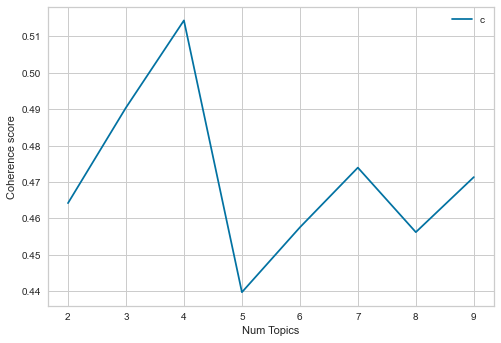

Num Topics = 2  has Coherence Value of 0.4642
Num Topics = 3  has Coherence Value of 0.4905
Num Topics = 4  has Coherence Value of 0.5144
Num Topics = 5  has Coherence Value of 0.4397
Num Topics = 6  has Coherence Value of 0.4576
Num Topics = 7  has Coherence Value of 0.474
Num Topics = 8  has Coherence Value of 0.4562
Num Topics = 9  has Coherence Value of 0.4714


In [ ]:
# Calculer les scores de cohérence entre 2 et 10 topics (Cela peut prendre un certain temps)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=10, step=1)

# Afficher un graphique
limit=10
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Affchier les coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))  #le 4 correspond au nombre de décimales du c

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.036*"food" + 0.028*"service" + 0.027*"time" + 0.025*"place" + 0.018*"minutes" + 0.017*"order" + 0.014*"people" + 0.012*"customer" + 0.011*"manager" + 0.011*"experience"'), (1, '0.018*"chicken" + 0.013*"sauce" + 0.012*"fries" + 0.011*"salad" + 0.009*"steak" + 0.009*"burger" + 0.009*"cream" + 0.009*"ice" + 0.008*"plate" + 0.008*"friends"'), (2, '0.014*"floor" + 0.011*"woman" + 0.010*"fact" + 0.010*"hair" + 0.009*"meat" + 0.009*"nails" + 0.007*"gas" + 0.007*"daughter" + 0.007*"bathroom" + 0.007*"pork"'), (3, '0.028*"car" + 0.025*"room" + 0.012*"day" + 0.011*"hotel" + 0.011*"company" + 0.009*"door" + 0.008*"days" + 0.007*"work" + 0.007*"months" + 0.007*"card"')]


In [123]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews["words_token_lem"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.80675728051003

Coherence Score:  0.42192295065090557


In [169]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)

OSError: [Errno 22] Invalid argument

In [170]:
import pyLDAvis.gensim

%matplotlib inline
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)

OSError: [Errno 22] Invalid argument

In [151]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=custom_tokenizer)
dtm = cv.fit_transform(reviews['words_token_lem'])

NameError: name 'custom_tokenizer' is not defined

In [124]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.036*"food" + 0.028*"service" + 0.027*"time" + 0.025*"place" + '
  '0.018*"minutes" + 0.017*"order" + 0.014*"people" + 0.012*"customer" + '
  '0.011*"manager" + 0.011*"experience"'),
 (1,
  '0.018*"chicken" + 0.013*"sauce" + 0.012*"fries" + 0.011*"salad" + '
  '0.009*"steak" + 0.009*"burger" + 0.009*"cream" + 0.009*"ice" + '
  '0.008*"plate" + 0.008*"friends"'),
 (2,
  '0.014*"floor" + 0.011*"woman" + 0.010*"fact" + 0.010*"hair" + 0.009*"meat" '
  '+ 0.009*"nails" + 0.007*"gas" + 0.007*"daughter" + 0.007*"bathroom" + '
  '0.007*"pork"'),
 (3,
  '0.028*"car" + 0.025*"room" + 0.012*"day" + 0.011*"hotel" + 0.011*"company" '
  '+ 0.009*"door" + 0.008*"days" + 0.007*"work" + 0.007*"months" + '
  '0.007*"card"')]


In [125]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.7811   
1            1             3.0              0.7123   
2            2             0.0              0.5944   
3            3             3.0              0.6547   
4            4             0.0              0.5039   
5            5             0.0              0.8251   
6            6             0.0              0.6529   
7            7             1.0              0.5266   
8            8             0.0              0.8220   
9            9             0.0              0.6980   

                                                                            Keywords  \
0                     car, room, day, hotel, company, door, days, work, months, card   
1                     car, room, day, hotel, company, door, days, work, months, card   
2  food, service, time, place, minutes, order, people, customer, manager, experience   
3                     car, room, day, hotel, company, door, days, work, months, card   
4  food, service, time, place, minutes, order, people, customer, manager, experience   
5  food, service, time, place, minutes, order, people, customer, manager, experience   
6  food, service, time, place, minutes, order, people, customer, manager, experience   
7            chicken, sauce, fries, salad, steak, burger, cream, ice, plate, friends   
8  food, service, time, place, minutes, order, people, customer, manager, experience   
9  food, service, time, place, minutes, order, people, customer, manager, experience   

                                                               Text  
0                                                               NaN  
1                                                               NaN  
2                                                               NaN  
3                                                               NaN  
4    [gyro, hopes, chicken, thing, mess, way, hummus, flavors, eat]  
5                                                               NaN  
6                                                               NaN  
7                                                               NaN  
8                   [guy, counter, days, customer, service, skills]  
9  [front, desk, rudest, people, check, lunch, girl, places, order]

In [126]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet 

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9574   
1        1.0              0.8001   
2        2.0              0.6732   
3        3.0              0.8830   

                                                                            Keywords  \
0  food, service, time, place, minutes, order, people, customer, manager, experience   
1            chicken, sauce, fries, salad, steak, burger, cream, ice, plate, friends   
2               floor, woman, fact, hair, meat, nails, gas, daughter, bathroom, pork   
3                     car, room, day, hotel, company, door, days, work, months, card   

                                                                                   Representative Text  
0  [wings, service, server, food, playing, hair, waitress, suggestions, wings, sauce, wings, servic...  
1                                                                                                  NaN  
2  [experience, day, experience, service, food, people, sent, food, version, watery, soggy, greens,...  
3  [hate, service, store, kenner, loyola, service, hut, stores, pizza, deliver, tell, cancel, order...

In [127]:
gc.collect()

18412

In [80]:
df_dominant_topic_sub

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
22             22             0.0              0.4296   
29             29             0.0              0.6144   
52             52             0.0              0.5126   
55             55             0.0              0.5503   
56             56             0.0              0.5532   
...           ...             ...                 ...   
1935         1935             0.0              0.4919   
1944         1944             0.0              0.5326   
1976         1976             0.0              0.3643   
1983         1983             0.0              0.4010   
1999         1999             0.0              0.4776   

                                                             Keywords  \
22    car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
29    car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
52    car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
55    car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
56    car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
...                                                               ...   
1935  car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
1944  car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
1976  car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
1983  car, lunch, hair, employee, oil, massage, guess, sign, lot, see   
1999  car, lunch, hair, employee, oil, massage, guess, sign, lot, see   

                                                                                                     Text  
22                                                                                                    NaN  
29    [shopping, menards, peters, experience, today, location, bag, way, store, towards, entrance, cra...  
52                                                                                                    NaN  
55                                                                                                    NaN  
56                                                                                                    NaN  
...                                                                                                   ...  
1935  [place, brother, lease, numbers, times, site, advertises, lot, brother, price, unbeknownst, leas...  
1944                                                                                                  NaN  
1976                                                                                                  NaN  
1983                                                                                                  NaN  
1999                                 [time, service, food, table, garbage, table, someone, customer, tea]  

[151 rows x 5 columns]

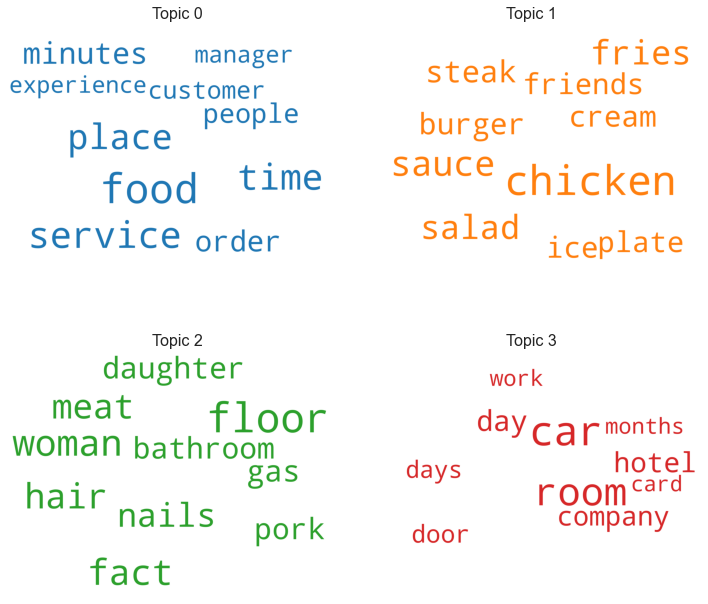

In [129]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\aurel\AppData\Local\Temp\ipykernel_13292\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_13292\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_13292\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\aurel\AppData\Local\Temp\ipykernel_13292\2913163039.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



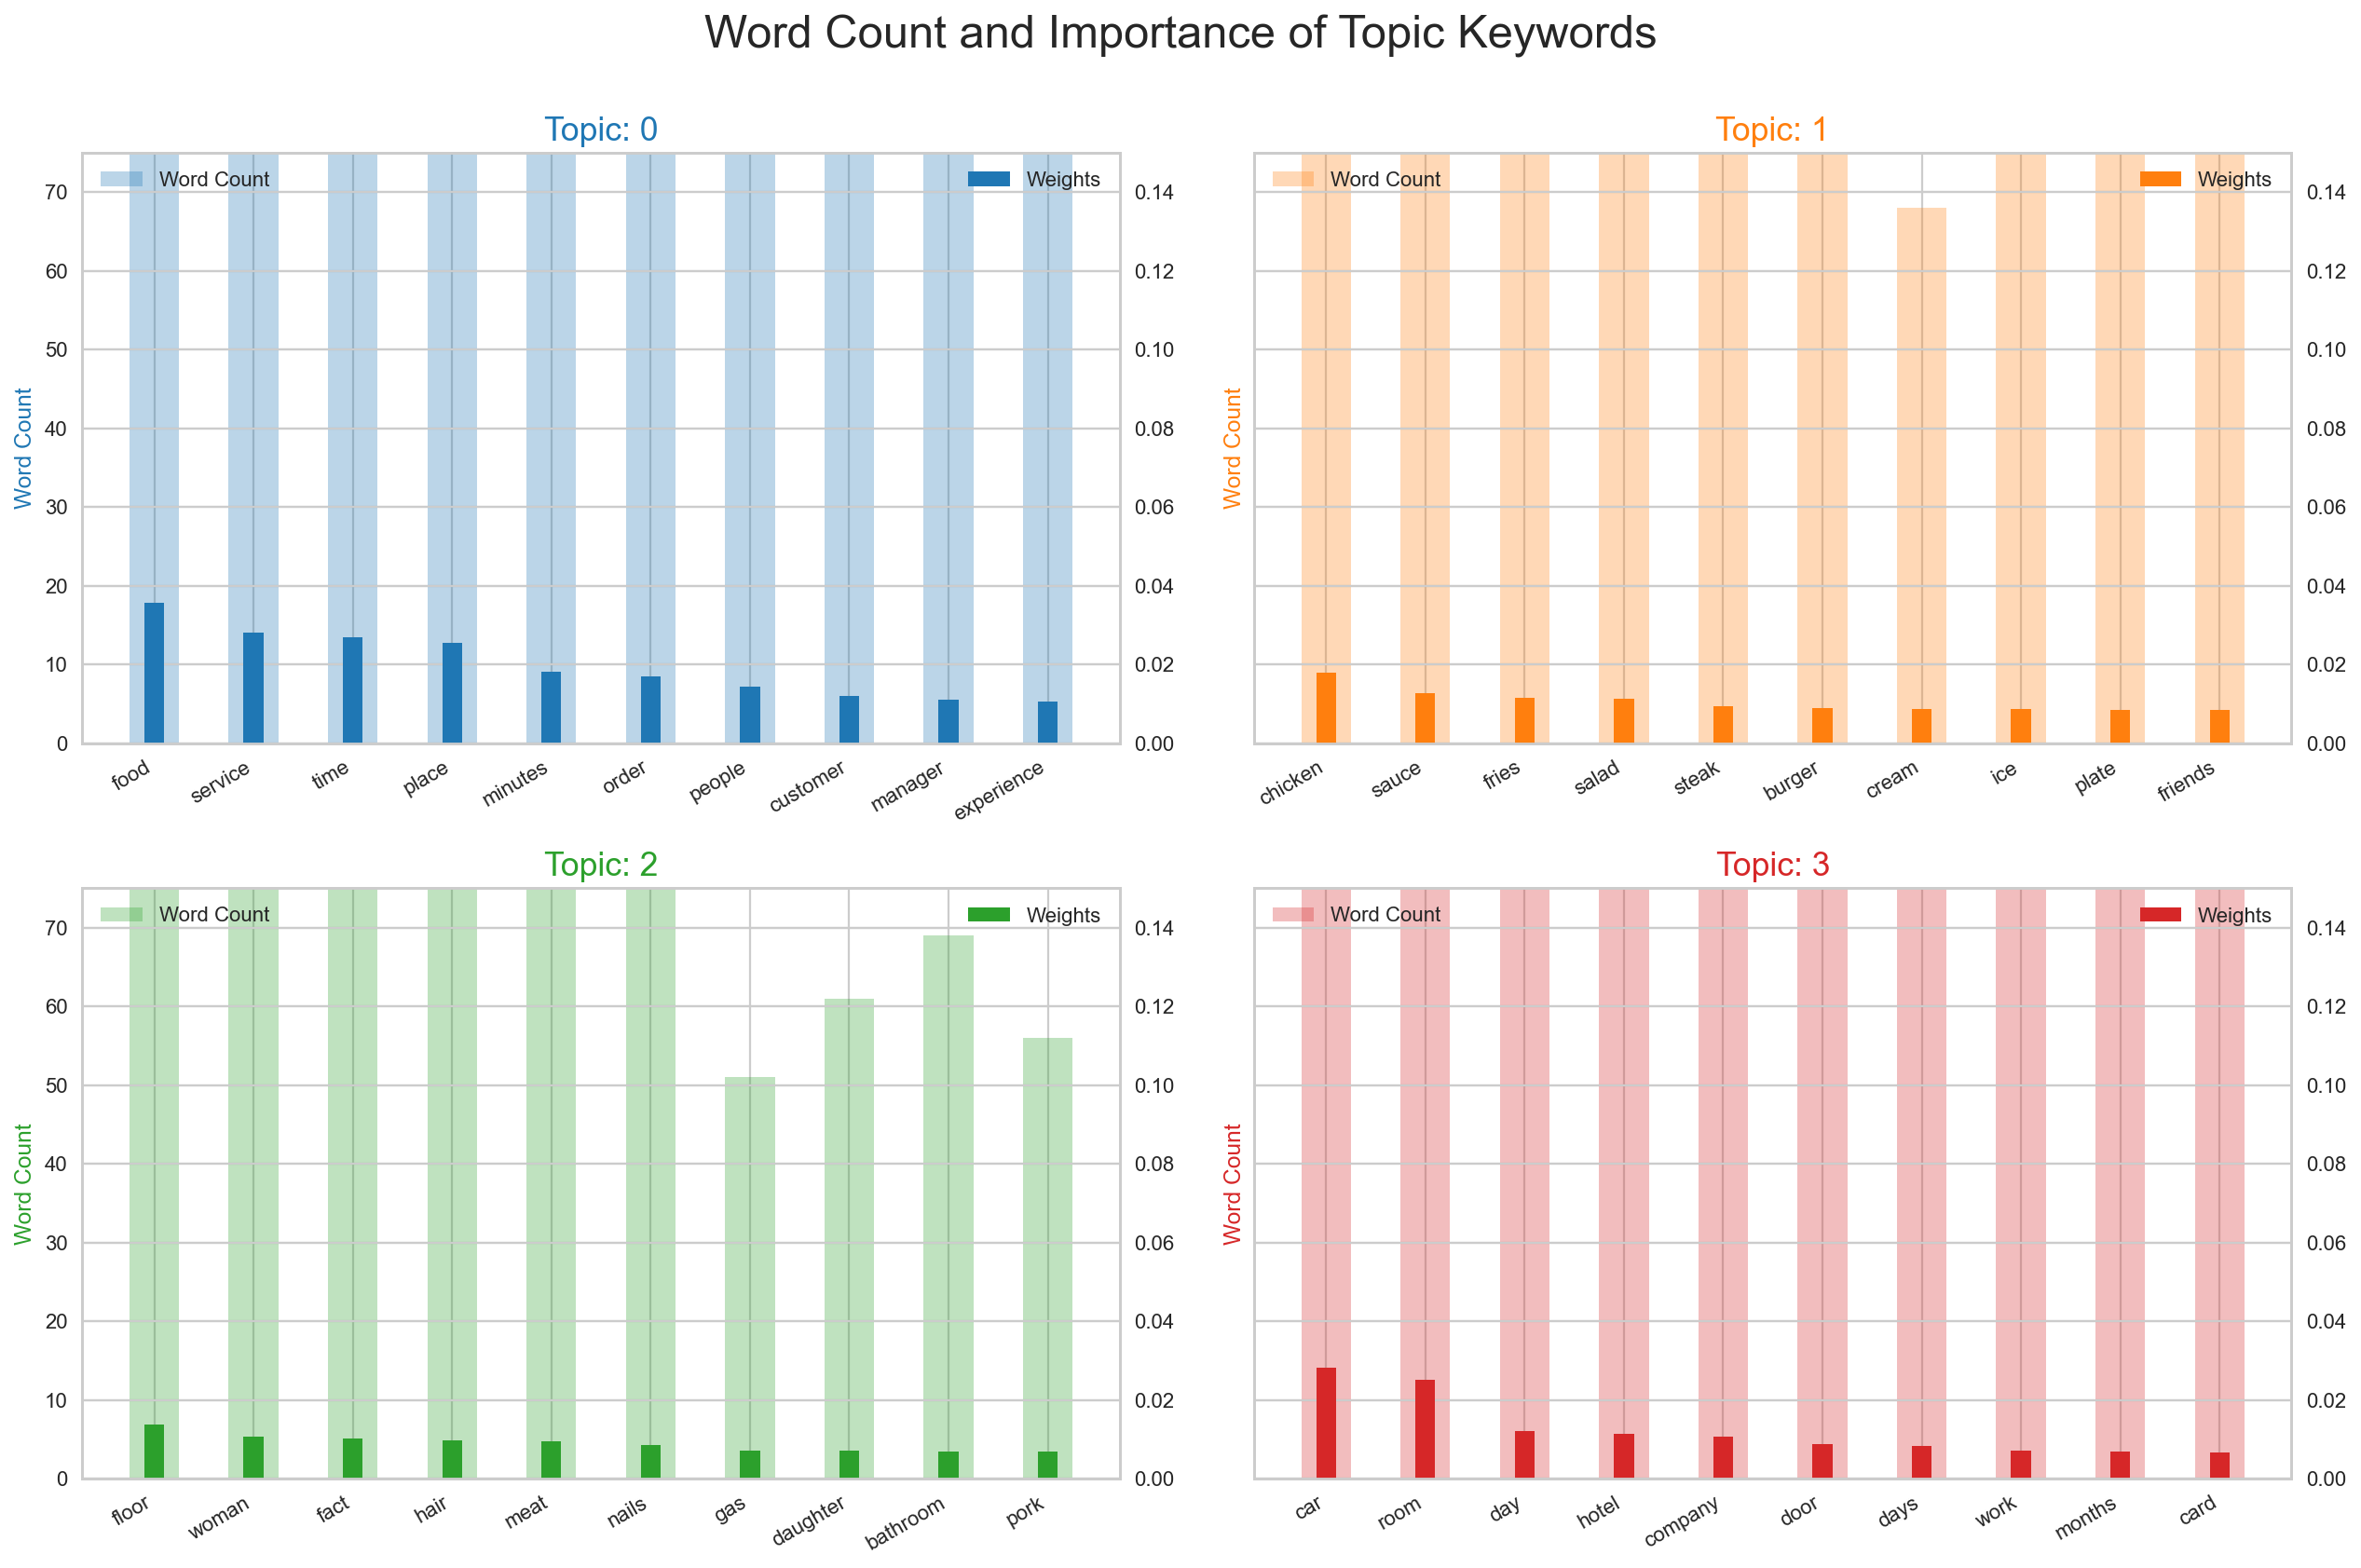

In [130]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.15); ax.set_ylim(0, 75)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

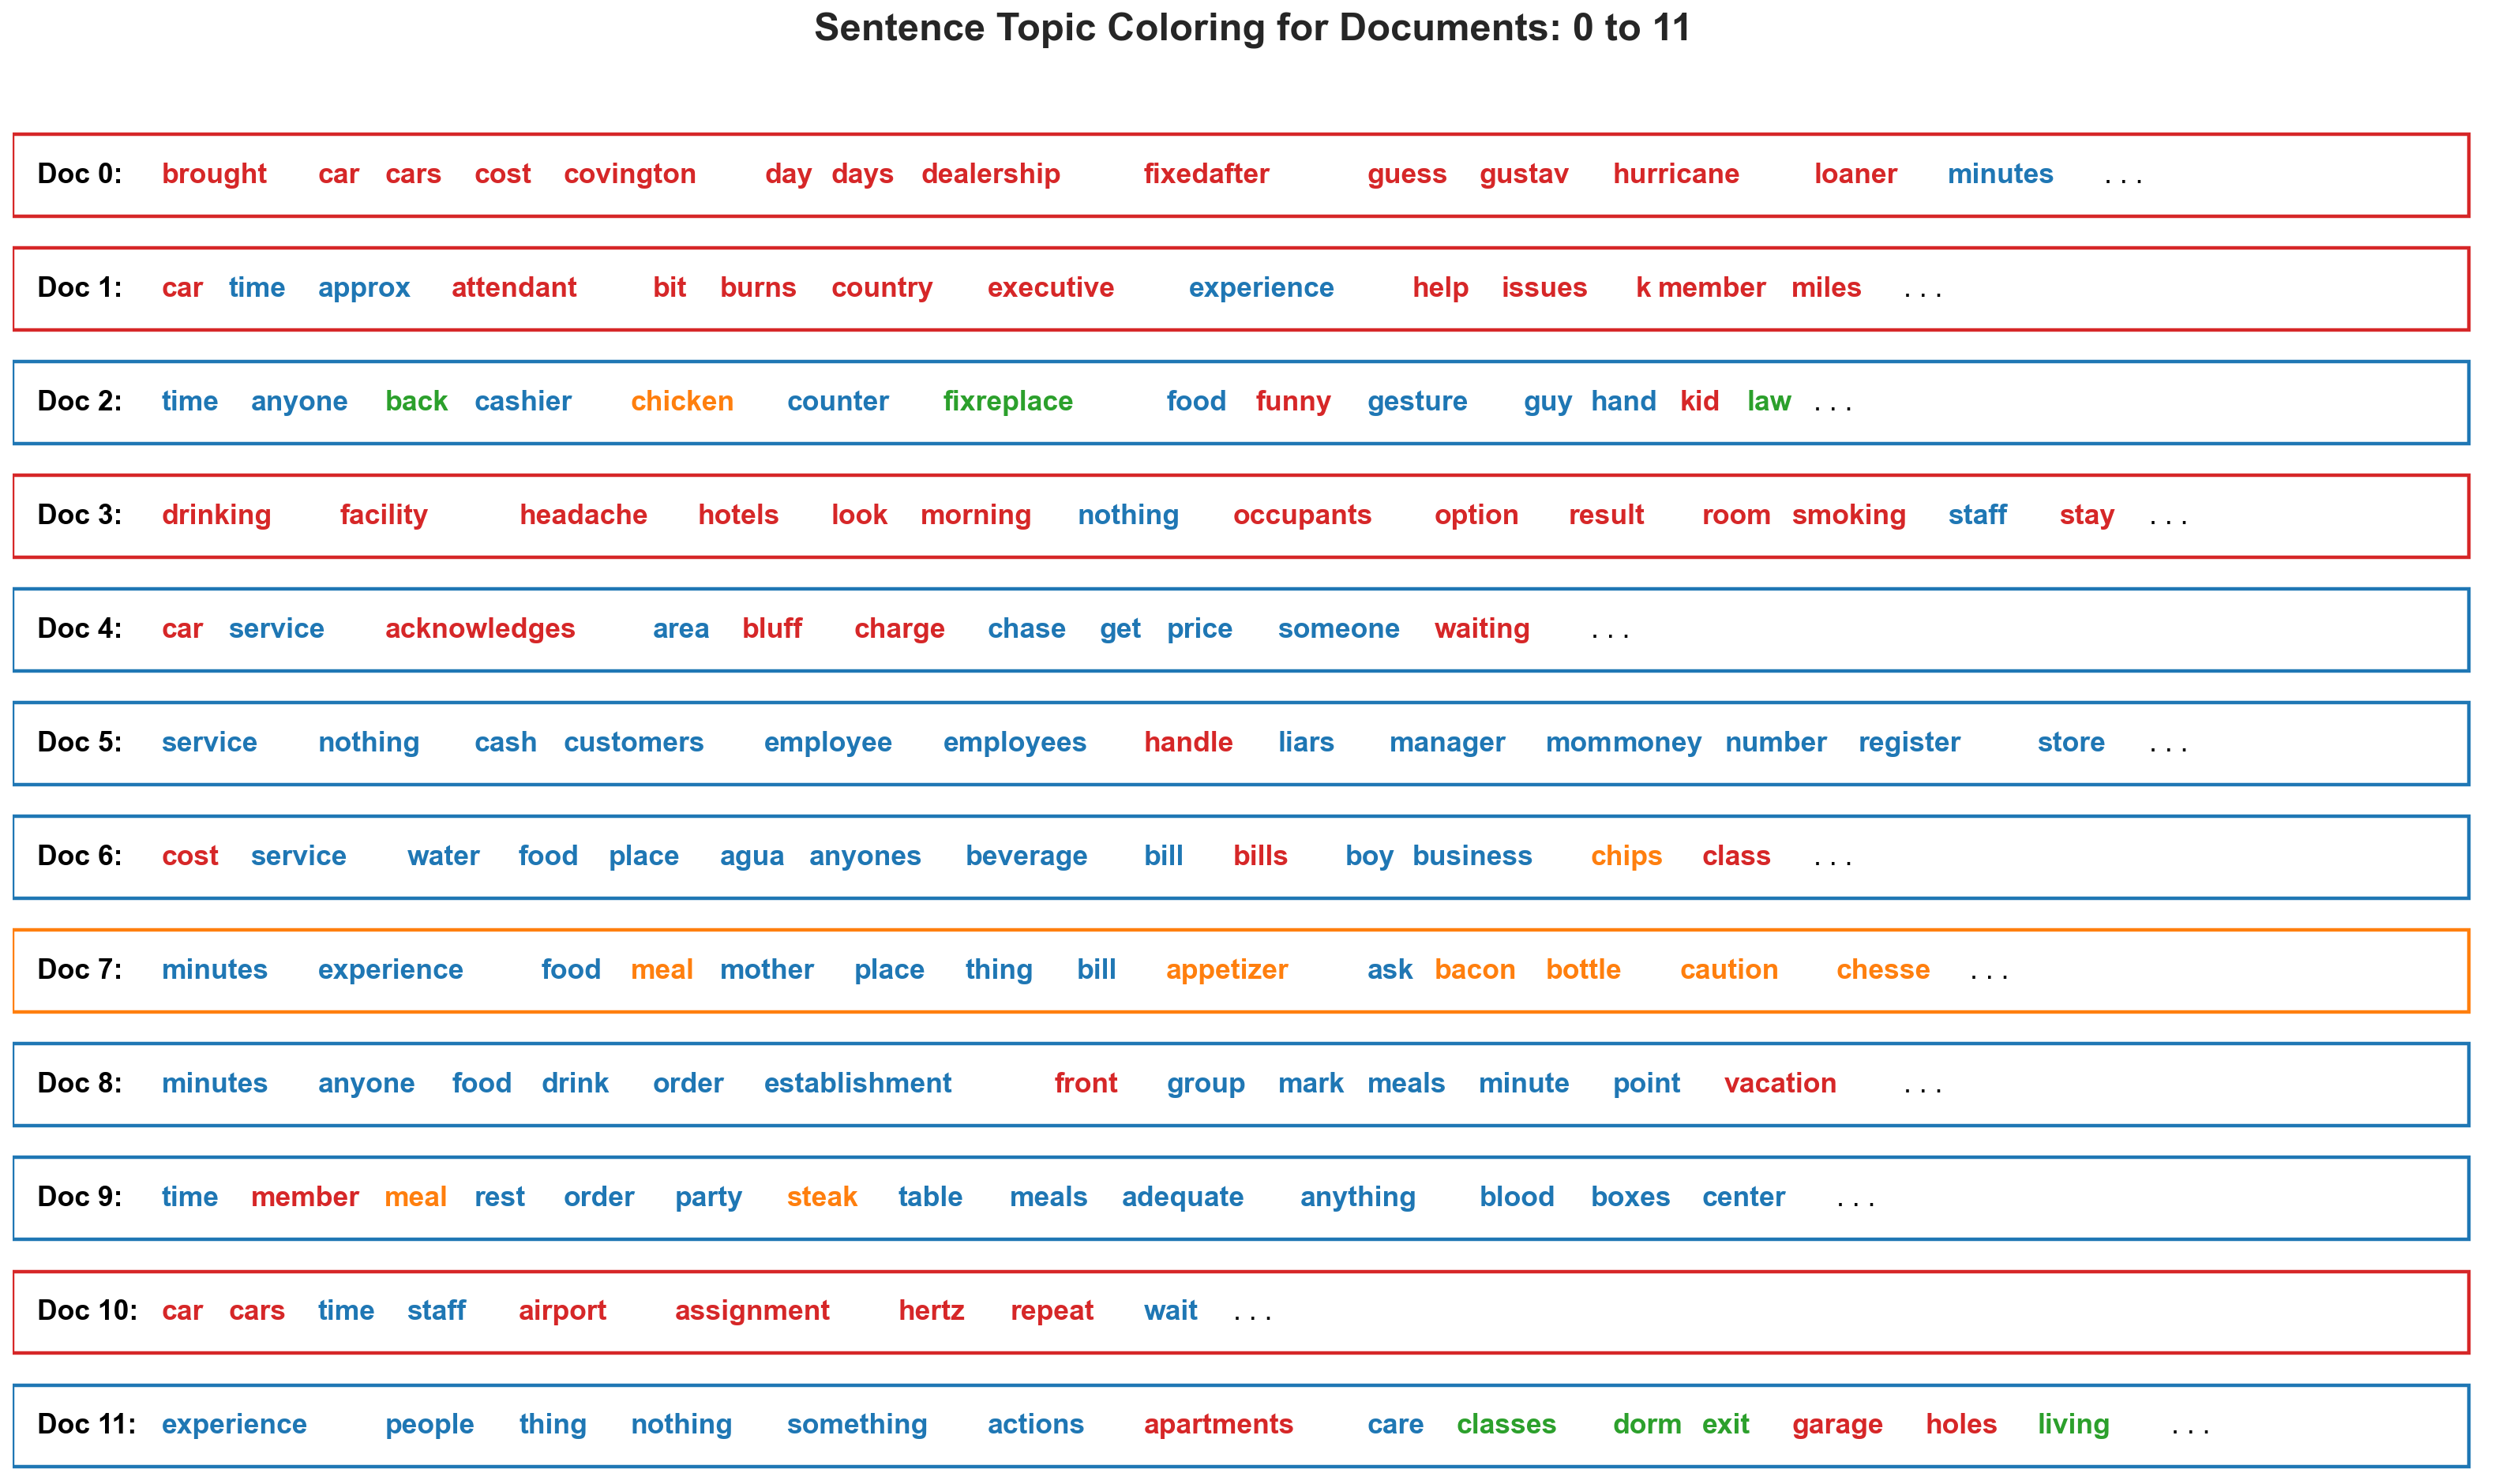

In [131]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [173]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2985 samples in 0.002s...
[t-SNE] Computed neighbors for 2985 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2985
[t-SNE] Computed conditional probabilities for sample 2000 / 2985
[t-SNE] Computed conditional probabilities for sample 2985 / 2985
[t-SNE] Mean sigma: 0.021083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.114342
[t-SNE] KL divergence after 1000 iterations: 0.733914


D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



Loading BokehJS ...

D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\bokeh\io\notebook.py:487: DeprecationWarning:

The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.



In [174]:
gc.collect()

16668

# word2vect

In [175]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

In [176]:
review_text = reviews["words_token_lem"]

In [177]:
model.build_vocab(review_text, progress_per=1000)

In [178]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(301862, 369240)

In [180]:
model.wv.most_similar("food")

[('drinks', 0.9998747706413269),
 ('waitress', 0.9998666048049927),
 ('order', 0.9998623728752136),
 ('waiter', 0.9998460412025452),
 ('lunch', 0.9998371601104736),
 ('server', 0.999826192855835),
 ('meal', 0.9998186230659485),
 ('salad', 0.9998024702072144),
 ('fries', 0.9998009204864502),
 ('restaurant', 0.9997923374176025)]

In [192]:
list(model.wv.vocab)

['dealership',
 'volkswagen',
 'water',
 'car',
 'time',
 'weeks',
 'brought',
 'day',
 'tomorrow',
 'loaner',
 'cars',
 'days',
 'hurricane',
 'guess',
 'minutes',
 'cost',
 'part',
 'walker',
 'take',
 'service',
 'executive',
 'member',
 'country',
 'vehicle',
 'approx',
 'k',
 'miles',
 'seats',
 'scratches',
 'attendant',
 'bit',
 'help',
 'issues',
 'experience',
 'food',
 'okay',
 'man',
 'guy',
 'people',
 'cashier',
 'mother',
 'things',
 'thing',
 'counter',
 'chicken',
 'pork',
 'back',
 'kid',
 'hand',
 'gesture',
 'funny',
 'place',
 'anyone',
 'way',
 'women',
 'meal',
 'rest',
 'safety',
 'law',
 'stay',
 'hotels',
 'facility',
 'occupants',
 'room',
 'morning',
 'smoking',
 'drinking',
 'staff',
 'nothing',
 'result',
 'headache',
 'look',
 'option',
 'area',
 'price',
 'charge',
 'waiting',
 'chase',
 'someone',
 'get',
 'employees',
 'liars',
 'handle',
 'customers',
 'money',
 'number',
 'employee',
 'manager',
 'cash',
 'register',
 'store',
 'mom',
 'mole',
 'enchi

In [193]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]

In [218]:
nlp = model.wv

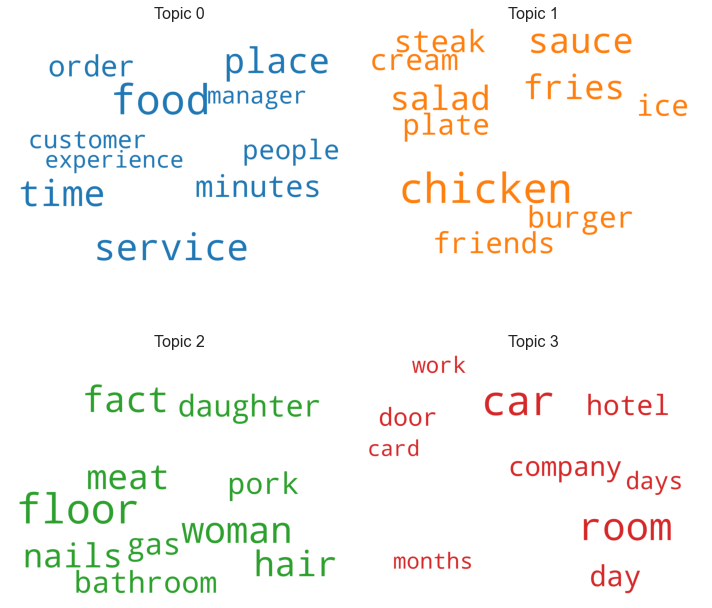

In [219]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [223]:
vocab

['dealership',
 'volkswagen',
 'water',
 'car',
 'time',
 'weeks',
 'brought',
 'day',
 'tomorrow',
 'loaner',
 'cars',
 'days',
 'hurricane',
 'guess',
 'minutes',
 'cost',
 'part',
 'walker',
 'take',
 'service',
 'executive',
 'member',
 'country',
 'vehicle',
 'approx',
 'k',
 'miles',
 'seats',
 'scratches',
 'attendant',
 'bit',
 'help',
 'issues',
 'experience',
 'food',
 'okay',
 'man',
 'guy',
 'people',
 'cashier',
 'mother',
 'things',
 'thing',
 'counter',
 'chicken',
 'pork',
 'back',
 'kid',
 'hand',
 'gesture',
 'funny',
 'place',
 'anyone',
 'way',
 'women',
 'meal',
 'rest',
 'safety',
 'law',
 'stay',
 'hotels',
 'facility',
 'occupants',
 'room',
 'morning',
 'smoking',
 'drinking',
 'staff',
 'nothing',
 'result',
 'headache',
 'look',
 'option',
 'area',
 'price',
 'charge',
 'waiting',
 'chase',
 'someone',
 'get',
 'employees',
 'liars',
 'handle',
 'customers',
 'money',
 'number',
 'employee',
 'manager',
 'cash',
 'register',
 'store',
 'mom',
 'mole',
 'enchi

In [227]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["FOOD"] = get_similar_words(['drink', 'salad','pizza','fries', 'sauce'], 
                  top=30, nlp=nlp)
dic_clusters["DIRTY"] = get_similar_words(['nail','hair', 'bathroom', 'floor']
                  , top=30, nlp=nlp)
dic_clusters["SERVICE"] = get_similar_words(['employees','time','order','experience','minutes'], 
                   top=30, nlp=nlp)
dic_clusters["PLACE"] = get_similar_words(['people','car','room','card'], 
                   top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

FOOD :  ['salad', 'bland', 'taste', 'beer', 'menu'] ... 35
DIRTY :  ['thing', 'year', 'area', 'fact', 'nothing'] ... 34
SERVICE :  ['orders', 'anything', 'experience', 'beer', 'couple'] ... 35
PLACE :  ['office', 'payment', 'people', 'months', 'weeks'] ... 34


In [194]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [195]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

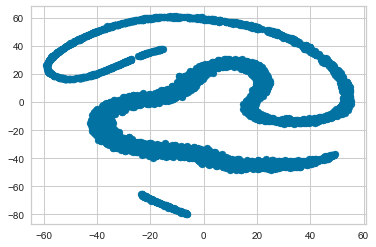

In [196]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

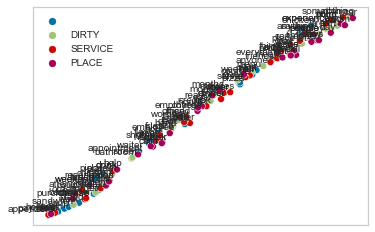

In [228]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## Bert

In [20]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
import transformers

In [21]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
gc.collect()

136

In [23]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
## create list of news vector
reviews["lst_mean_vecs"] = reviews["words_token_lem"].progress_apply(lambda x: utils_bert_embedding(x, tokenizer, nlp).mean(0))
## create the feature matrix (n news x 768)
X = np.array(reviews["lst_mean_vecs"])

  0%|          | 0/3000 [00:00<?, ?it/s]

In [213]:
lst_mean_vecs.head(2)

1539    [0.20330188, 0.09459509, 0.58471763, 0.004131913, 0.36366627, 0.15404022, 0.1919533, 0.11373451,...
2522    [-0.2861421, -0.051985484, 0.4750504, 0.022698779, 0.46439838, -0.073876806, 0.21362832, -0.1312...
Name: words_token_lem, dtype: object

In [64]:
X = reviews["lst_mean_vecs"]

In [65]:
X

2027    [0.6524005, 0.06790703, 0.10968186, -0.3653933...
4390    [0.32234558, 0.18651718, 0.5200471, -0.2120879...
5576    [0.19019619, 0.023641637, 0.92803496, 0.106621...
2134    [0.06914384, 0.044071518, 0.5098958, -0.073195...
5481    [0.28648904, -0.44488707, 0.37287498, -0.23274...
                              ...                        
9015    [0.1776367, -0.091883086, 0.20754234, -0.35490...
1812    [0.18353468, 0.13024592, 0.52855575, -0.281933...
1823    [0.4063822, -0.008520312, 0.7154928, -0.274137...
6505    [0.38022834, -0.021567453, -0.08454664, -0.065...
4918    [0.13141479, 0.32935503, 0.4923071, -0.1926706...
Name: lst_mean_vecs, Length: 3000, dtype: object

In [27]:
gc.collect()

0

In [46]:
len(X[0])

768

In [57]:
type(reviews["lst_mean_vecs"])

pandas.core.series.Series

In [67]:

%timeit X_feats = pd.DataFrame(item for item in X)

589 ms ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
X_feats

0
2027 NaN
4390 NaN
5576 NaN
2134 NaN
5481 NaN
...   ..
9015 NaN
1812 NaN
1823 NaN
6505 NaN
4918 NaN

[3000 rows x 1 columns]

In [72]:
series = pd.Series(X)
X_feats = pd.DataFrame(item for item in series)

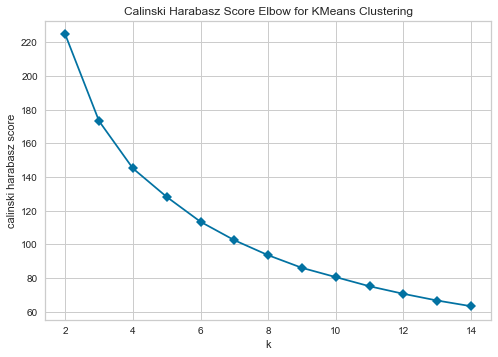

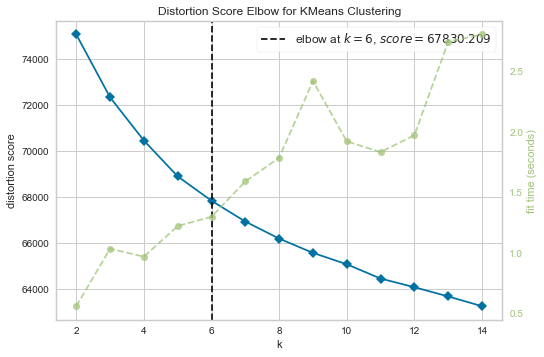

In [73]:
pk_multi_unsp.amulti_kmeans_elbow(X_feats)

In [ ]:
from sklearn.cluster import KMeans

# elbow method
# squared distance
sse = []
list_k = [4, 6, 8, 10]

for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

2027    [0.6524005, 0.06790703, 0.10968186, -0.3653933...
4390    [0.32234558, 0.18651718, 0.5200471, -0.2120879...
5576    [0.19019619, 0.023641637, 0.92803496, 0.106621...
2134    [0.06914384, 0.044071518, 0.5098958, -0.073195...
5481    [0.28648904, -0.44488707, 0.37287498, -0.23274...
                              ...                        
9015    [0.1776367, -0.091883086, 0.20754234, -0.35490...
1812    [0.18353468, 0.13024592, 0.52855575, -0.281933...
1823    [0.4063822, -0.008520312, 0.7154928, -0.274137...
6505    [0.38022834, -0.021567453, -0.08454664, -0.065...
4918    [0.13141479, 0.32935503, 0.4923071, -0.1926706...
Name: lst_mean_vecs, Length: 3000, dtype: object

ERROR! Session/line number was not unique in database. History logging moved to new session 602


In [76]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(0, X_feats, 6, 500, 0)

Silhouette Coefficient:  0.02625322  - nb clusters :  6
-----------------------------------------------------------------------------------


In [77]:
df_km = pk_multi_unsp.kmplus_assignclass(reviews,X_feats, 6, 1000)

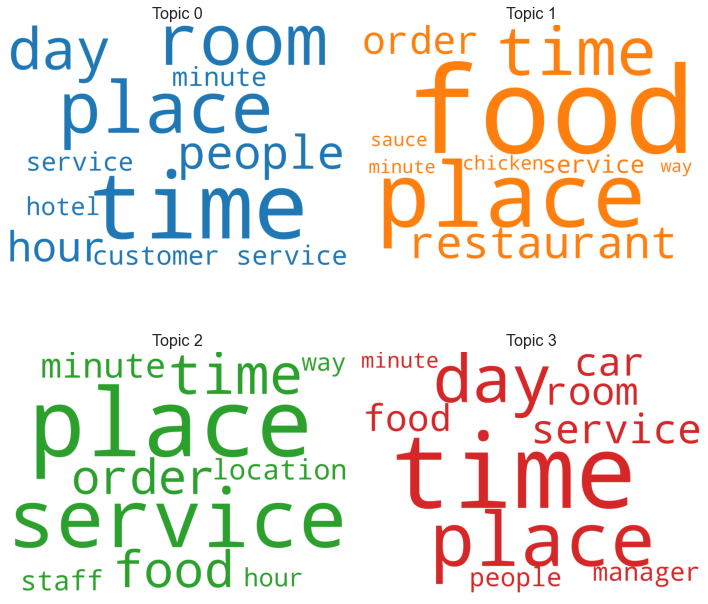

In [78]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = df_km

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = df_km["words_subjects_lem"].loc[df_km["classe"]==i]
    all_reviews = topic_words.str.cat(sep=' ')
    cloud.generate(all_reviews)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### K-means

df_acp2

In [87]:
df_acp2

NameError: name 'df_acp2' is not defined

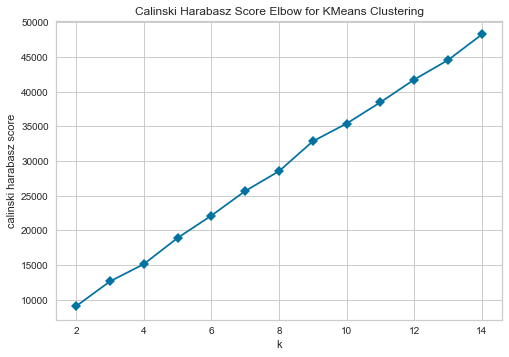

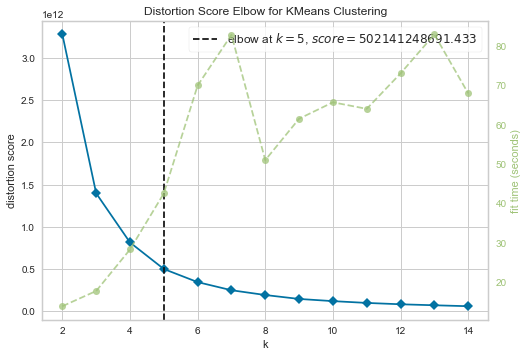

In [94]:
pk_multi_unsp.amulti_kmeans_elbow(df_acp2)

In [84]:
X = df_acp2.copy()

In [90]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 8, 500, 0)

Silhouette Coefficient:  0.202936559890454  - nb clusters :  8
-----------------------------------------------------------------------------------


In [ ]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 4, 500, 0)

In [93]:
silhouette, cluster_res = pk_multi_unsp.kmsplus_iter(1, X, 5, 500, 0)

MemoryError: Unable to allocate 1.92 GiB for an array with shape (7000, 36806) and data type float64

In [6]:
gc.collect()

790

In [102]:
df_km = pk_multi_unsp.kmplus_assignclass(reviews,X, 5, 1000)

In [103]:
df_km["words_token_lem"].head(2)

8747    [dunkin, donuts, people, line, drivethru, street, minutes, people, restaurant, breakfast, place,...
3384    [shore, mall, today, florida, product, goodness, find, offer, orders, cinnamon, pretzel, annes, ...
Name: words_token_lem, dtype: object

In [390]:
df_km.head(2)

level_0                   rw_id  rw_rating  \
0     3427  3m2Z9mMC5rLcynKFCZGcsQ          1   
1    41990  6recrX_SsLVf-WjIgtCvXA          1   

                                                                                               rw_text  \
0  shocking lifetime titanium member who cares  everyone is treated like dirt at this property many...   
1  the companys incompetence  is incredible becky the one who writes reviews to all of the posts sa...   

                                                                                              new_text  \
0  shocking lifetime titanium member  cares  everyone  treated like dirt   property many restaurant...   
1   companys incompetence   incredible becky  one  writes reviews     posts saying  same thing info...   

                                                                                     text_tagged_nn_vb  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

                                                                                        words_subjects  \
0  [titanium, member, everyone, dirt, property, restaurants, number, people, conventions, service, ...   
1  [companys, incompetence, posts, thing, information, documents, appeal, claim, customer, services...   

                                                                                     words_subjects_st  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                    words_subjects_lem  \
0  titanium member everyone dirt property restaurants number people conventions service marriott pr...   
1  companys incompetence posts thing information documents appeal claim customer services informati...   

                                                                                  text_tagged_nn_vb_st  \
0  shocking lifetime titanium member cares everyone treated dirt property many restaurants overblow...   
1  companys incompetence incredible becky writes reviews posts saying same thing informed img requi...   

   ... zocdoc_tfidf  zollinger_tfidf  zollingers_tfidf  zombie_tfidf  \
0  ...          0.0              0.0               0.0           0.0   
1  ...          0.0              0.0               0.0           0.0   

   zone_tfidf zoo_tfidf  zoodles_tfidf  zoom_tfidf  zucchini_tfidf  classe  
0         0.0       0.0            0.0         0.0             0.0       0  
1         0.0       0.0            0.0         0.0             0.0       0  

[2 rows x 26613 columns]

In [391]:
df_km["classe"]

array([0, 1, 3, 4, 2])

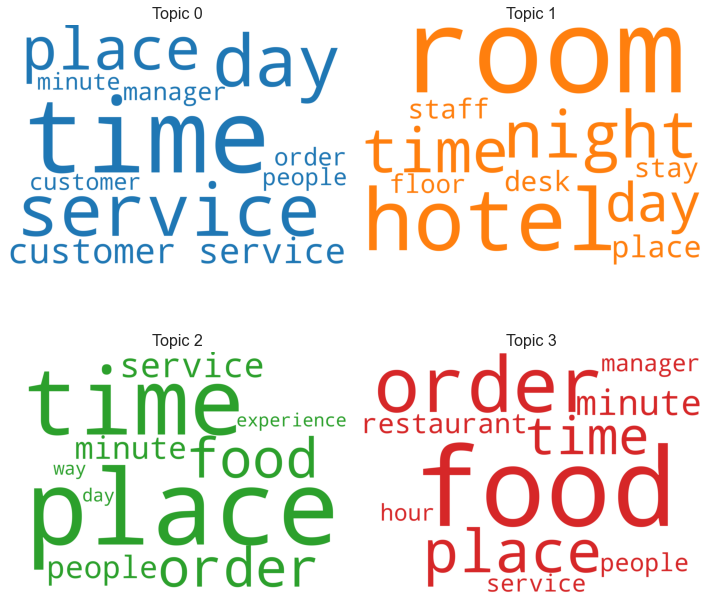

In [107]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = df_km

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = df_km["words_subjects_lem"].loc[df_km["classe"]==i]
    all_reviews = topic_words.str.cat(sep=' ')
    cloud.generate(all_reviews)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [99]:
for i in df_km.columns:
    print(i)

rw_id
rw_rating
rw_text
new_text
text_tagged_nn_vb
words_subjects
words_subjects_st
words_subjects_lem
text_tagged_nn_vb_st
text_nn_vb_lem_feels
feeling_neg
feeling_neu
feeling_pos
feeling_compound
feeling_avg
aaa
aaand
aand
aaron
aarrrgghhh
aback
abacus
abalone
abandon
abbreviate
abc
abdul
aber
aberration
abides
abilities
abilitiesi
ability
abington
abortion
abouttables
abraham
abrupt
absecent
absence
absent
absolument
absolute
absolutley
absorption
absurd
abt
abu
abundance
abundant
abura
abuse
abysmal
ac
academy
acai
accelerationwe
accent
accents
accept
acceptablewill
acceptance
accepting
accepts
access
accessibility
accessories
accessory
accident
accidentnew
accidents
accommodate
accommodating
accommodation
accommodations
accomodate
accomodating
accompaniments
accomplishment
accord
account
accountability
accounti
accounts
accross
acct
accuracy
accurate
accusation
accusatory
accuse
accustom
ace
aces
acetone
ache
aches
acid
acidity
acknowledge
acknowledged
acknowledgement
acknowledges

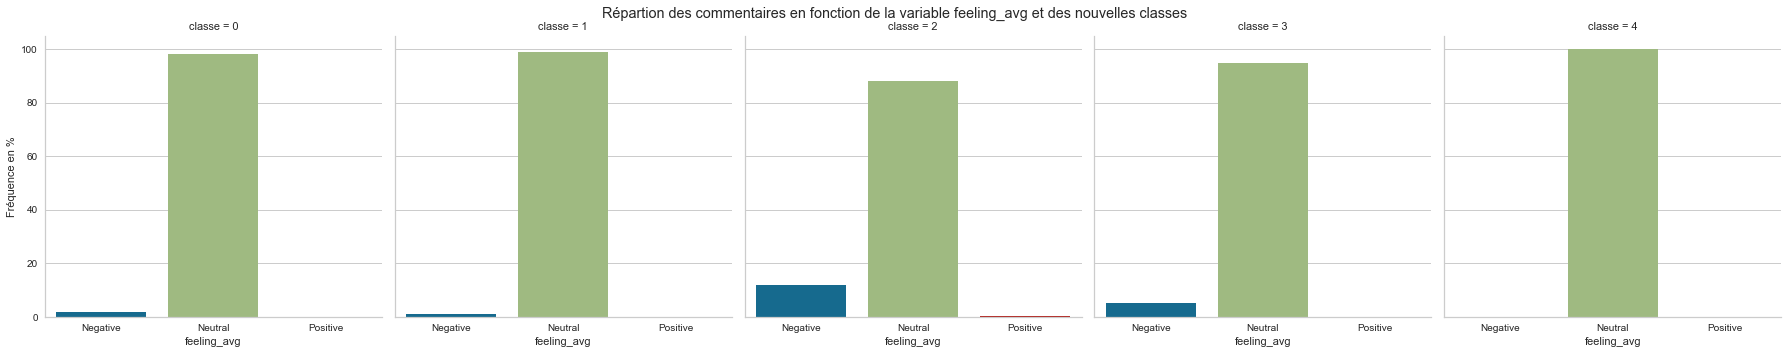

In [108]:
t = pd.crosstab(df_km.feeling_avg,
                df_km.classe,
                normalize="columns")
t = t.assign(feeling_avg=t.index)
tm = pd.melt(t, id_vars="feeling_avg")
tm = tm.assign(value=100 * tm.value)
ax=sns.catplot(x="feeling_avg",
               y="value", 
               col="classe",
               data=tm,
               kind="bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des commentaires en fonction de la variable feeling_avg et des nouvelles classes")
ax.set_axis_labels("feeling_avg","Fréquence en %")
plt.show()

# Classement des Photos

In [167]:
photos_json.groupby('label').count()

photo_id  business_id  caption  photo
label                                         
drink         200          200      200    200
food          200          200      200    200
inside        200          200      200    200
menu          200          200      200    200
outside       200          200      200    200

In [168]:
photos_json = photos_json_filt.copy()

In [169]:
photo_json_sav = photos_json.copy()

In [170]:
photos_json.head(2)

photo_id             business_id caption  label
19147  VVYOvXut5IMtyYd-7sXQWQ  cQS-U82tk0mxfja01D54lQ          drink
18732  THbzFcnVMJb7yxC3h7XcUw  WNcGg9G-odTGz00DSMx7rg          drink

In [171]:
photos_json["photo"] = "input\\yelp_photos\\photos\\" + photos_json["photo_id"] + ".jpg"

In [172]:
photos_json.head(2)

photo_id             business_id caption  label  \
19147  VVYOvXut5IMtyYd-7sXQWQ  cQS-U82tk0mxfja01D54lQ          drink   
18732  THbzFcnVMJb7yxC3h7XcUw  WNcGg9G-odTGz00DSMx7rg          drink   

                                                   photo  
19147  input\yelp_photos\photos\VVYOvXut5IMtyYd-7sXQW...  
18732  input\yelp_photos\photos\THbzFcnVMJb7yxC3h7XcU...

In [174]:
photos_json["photo"]

19147    input\yelp_photos\photos\VVYOvXut5IMtyYd-7sXQW...
18732    input\yelp_photos\photos\THbzFcnVMJb7yxC3h7XcU...
22228    input\yelp_photos\photos\p5NT7RwJ7NMsFhgcTdGDU...
15108    input\yelp_photos\photos\oO1k9vlqy15rni9lEj5He...
21919    input\yelp_photos\photos\x7qLkJQD8cpPZwQP7ohDW...
                               ...                        
2274     input\yelp_photos\photos\Dk4FvculKrMgijlJAumyr...
20937    input\yelp_photos\photos\9eL7zdqu5P3LdHUxPjGm9...
782      input\yelp_photos\photos\ekXjCRzEGZWuAUV5mI6DE...
15605    input\yelp_photos\photos\lMiQBi7mRJW_G6k7k3PLs...
7006     input\yelp_photos\photos\ILRePEnIK5PAvbB-qMxT9...
Name: photo, Length: 1000, dtype: object

In [175]:
photos_json.shape

(1000, 5)

In [124]:
graph_int_bar(photos_json['label'], 'Catégories', "Répartition des photos en fonction des catégories", 'rgb(96,27,0)')

<Figure size 576x936 with 0 Axes>

In [176]:
list_photos = photos_json["photo"]

In [177]:
data = photos_json.copy()

In [178]:
data.shape

(1000, 5)

Regardons 2 images par catégorie.

In [180]:
len(data)

1000

In [182]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["photo"][i] for i in range(len(data)) if data["label"][i]==name]
    return list_image_name

list_labels = ["drink", "food", "inside", "menu", "outside"]
list_drink=[list_photos[i] for i in range(len(data)) if data["label"][i]=="drink"]
list_food=[list_photos[i] for i in range(len(data)) if data["label"][i]=="food"]
list_inside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="inside"]
list_menu=[list_photos[i] for i in range(len(data)) if data["label"][i]=="menu"]
list_outside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="outside"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(2):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

KeyError: 0

Les images sont en couleur et de tailles différentes. Il convient donc de les mettre en gris et toutes à la même échelle.
Nous allons aussi améliorer le contraste, pour cela nous créons une fonction.

In [183]:
photos.head(2)

test = photos.head(1)

In [184]:
link = test["photos"]

In [185]:
link[0]

"['https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg']"

In [350]:
import urllib.request

print('Beginning file download with urllib2...')

url = "https://s3-media2.fl.yelpcdn.com/bphoto/TtMQlDyy7QUF4fDaxvqljg/o.jpg"


urllib.request.urlretrieve(url, 'input/download_photos/photo1.jpg')

Beginning file download with urllib2...


('input/download_photos/photo1.jpg',
 <http.client.HTTPMessage at 0x1d59300fa60>)

In [441]:
image = io.imread('input/download_photos/photo1.jpg')

In [442]:
# informations
print( 'classe :', type(image) )
print( 'type :', image.dtype )
print( 'taille :', image.shape )

classe : <class 'numpy.ndarray'>
type : uint8
taille : (750, 1000, 3)


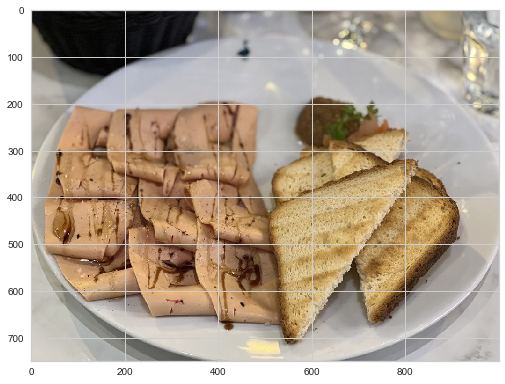

In [443]:
io.imshow(image)
io.show()

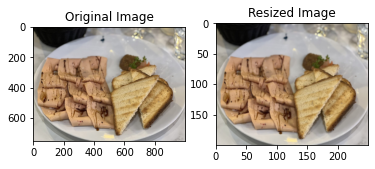

In [52]:

img_resized = resize(image, (200, 250))

#plot images
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_resized)
plt.title('Resized Image')
plt.show()

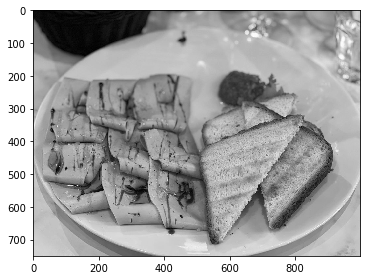

In [20]:
grey_image = color.rgb2gray( image )
io.imshow( grey_image )
io.show()

In [36]:
grey_image = grey_image*256

In [37]:
grey_image

array([[  5.94733176,   9.96301804,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       [  7.9551749 ,  10.96693961,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       [ 11.97086118,  12.97478275,  13.97870431, ..., 199.27552   ,
        199.27552   , 199.27552   ],
       ...,
       [209.44805647, 209.44805647, 209.44805647, ..., 195.39696941,
        195.39696941, 196.40089098],
       [209.44805647, 209.44805647, 209.44805647, ..., 194.39304784,
        195.39696941, 195.39696941],
       [209.44805647, 209.44805647, 209.44805647, ..., 194.39304784,
        194.39304784, 195.39696941]])

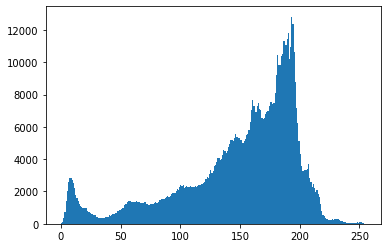

In [38]:
# Charger l'image comme matrice de pixels
img = np.array(grey_image)

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

In [186]:
from skimage import exposure

img_corrected = exposure.equalize_hist(grey_image)

NameError: name 'grey_image' is not defined

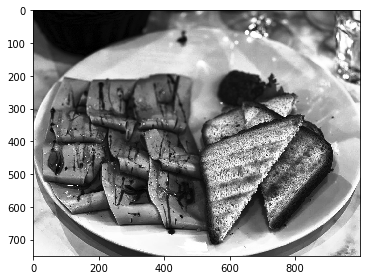

In [40]:
io.imshow(img_corrected)
io.show()

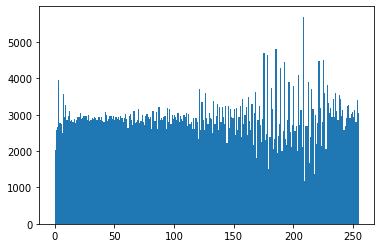

In [43]:
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True

img = np.array(img_corrected*256)
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Nous créons une fonction pour mettre toutes les images à la même échelle, mais aussi pour les mettre en gris et égaliser le contrate.

In [187]:
from skimage.transform import resize
from skimage import exposure

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io

from skimage import color, img_as_ubyte, img_as_float32
from numpy import expand_dims

In [257]:
#200, 250
from skimage import exposure
from keras.preprocessing.image import img_to_array

def clean_image(link_image, grey, float_img, size_l=224, size_h=224):
        image = io.imread(link_image)
        img_resized = resize(image, (size_l, size_h))
        if grey == 1:
            grey_image = color.rgb2gray( img_resized )
            img_corrected = exposure.equalize_hist(grey_image)
        elif grey==0:
            # img_resized = color.rgb2lab(img_resized)
            for channel in range(img_resized.shape[2]):  # equalizing each channel
                img_resized[:, :, channel] = exposure.equalize_hist(img_resized[:, :, channel])
                img_corrected = img_resized
            # img_corrected = exposure.equalize_hist(img_resized)
        if float_img == 1:
            img_corrected = img_as_ubyte(img_corrected)
        elif float_img == 2:
            #img_corrected = color.gray2rgb(img_corrected)
            img_corrected = img_to_array(img_corrected)
        return img_corrected

    

In [190]:
data["img_corrected"] = data["photo"].progress_apply(lambda x: clean_image(x, 1, 1, 224, 224))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [258]:
data["img_corrected_float"] = data["photo"].progress_apply(lambda x: clean_image(x, 0, 2, 224, 224))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [192]:
data["img_corrected_float_2"] = data["photo"].progress_apply(lambda x: clean_image(x, 1, 0, 224, 224))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [132]:
#data = data.loc[pd.isnull(data["img_corrected_float"]) == False]

In [148]:
data.shape

(1000, 8)

In [193]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data["label_num"] = le.fit_transform(data["label"])

In [479]:
data.head(2)

photo_id             business_id caption  label  \
19147  VVYOvXut5IMtyYd-7sXQWQ  cQS-U82tk0mxfja01D54lQ          drink   
18732  THbzFcnVMJb7yxC3h7XcUw  WNcGg9G-odTGz00DSMx7rg          drink   

                                                   photo  \
19147  input\yelp_photos\photos\VVYOvXut5IMtyYd-7sXQW...   
18732  input\yelp_photos\photos\THbzFcnVMJb7yxC3h7XcU...   

                                           img_corrected  \
19147  [[249, 251, 251, 251, 250, 248, 235, 210, 207,...   
18732  [[207, 209, 187, 210, 212, 220, 209, 202, 181,...   

                                     img_corrected_float  \
19147  [[[0.87283415, 0.9824196, 0.9705977], [0.87964...   
18732  [[[0.76731825, 0.8145884, 0.81732166], [0.7872...   

                                   img_corrected_float_2  label_num  \
19147  [[0.9776613161358809, 0.9833537617634384, 0.98...          0   
18732  [[0.8128340067318122, 0.820122589402312, 0.733...          0   

       tsne-2d-one  tsne-2d-two  
19147   -10.984679    -0.081522  
18732     5.711198     0.306836

In [481]:
data["img_corrected_float"].shape

(1000,)

In [36]:
import dill
dill.dump_session('notebook_envimg_4.db')

INFO:tensorflow:Assets written to: ram://b9616845-e961-4efa-9684-beb8c22fd60d/assets


In [8]:
import dill
dill.load_session('notebook_envimg_4.db')

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://add4fbf8-ee50-4861-8fd6-ebc39ee5207d/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [3]:
data.shape

(200, 9)

rotation + flou ????????????

In [497]:
from PIL import ImageFilter
import cv2
# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
#noisy_img.filter(ImageFilter.BoxBlur(1)).show()

In [511]:
photo_test = data["img_corrected_float_2"].head(1)

In [514]:
photo_test

array([array([[0.97766132, 0.98335376, 0.98528081, ..., 0.31596876, 0.32099373,
               0.33571148],
              [0.96951765, 0.97912968, 0.98429078, ..., 0.36306417, 0.36703469,
               0.37903952],
              [0.96770546, 0.97927345, 0.98335282, ..., 0.37995435, 0.38560402,
               0.40019648],
              ...,
              [0.02607253, 0.03313305, 0.10315768, ..., 0.60751445, 0.50532717,
               0.633308  ],
              [0.05434123, 0.01229065, 0.31568702, ..., 0.52888707, 0.49535663,
               0.55935831],
              [0.00258573, 0.01533249, 0.07006882, ..., 0.56916604, 0.57244505,
               0.49884384]])                                                   ],
      dtype=object)

In [515]:
photo_test = np.array(photo_test)

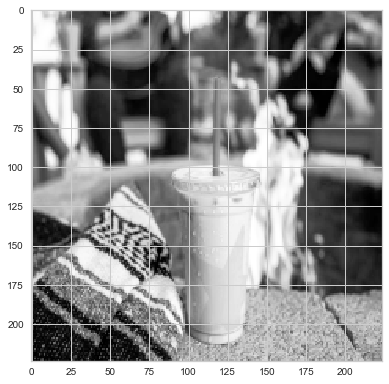

In [518]:
io.imshow(photo_test[0])
io.show()

In [519]:
gray1 = photo_test[0].copy()

In [520]:
gray1

array([[0.97766132, 0.98335376, 0.98528081, ..., 0.31596876, 0.32099373,
        0.33571148],
       [0.96951765, 0.97912968, 0.98429078, ..., 0.36306417, 0.36703469,
        0.37903952],
       [0.96770546, 0.97927345, 0.98335282, ..., 0.37995435, 0.38560402,
        0.40019648],
       ...,
       [0.02607253, 0.03313305, 0.10315768, ..., 0.60751445, 0.50532717,
        0.633308  ],
       [0.05434123, 0.01229065, 0.31568702, ..., 0.52888707, 0.49535663,
        0.55935831],
       [0.00258573, 0.01533249, 0.07006882, ..., 0.56916604, 0.57244505,
        0.49884384]])

Nous décidons de détecter les points clés à l'aide la méthode SIFT. Il existe d'autres méthodes mais, celle-ci assure une invariance à la rotation en trouvant l'orientation dominante dans un voisinage circulaire autour de chaque caractéristique détectée. 


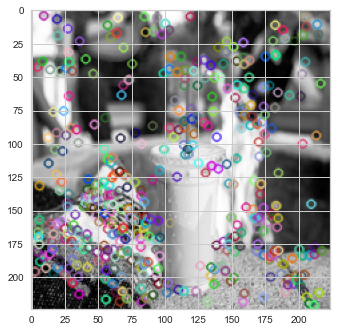

In [527]:
#keypoints

sift = cv2.xfeatures2d.SIFT_create()
image8bit = cv2.normalize(gray1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
keypoints_1, descriptors_1 = sift.detectAndCompute(image8bit,None)

img_1 = cv2.drawKeypoints(image8bit,keypoints_1,image8bit)
plt.imshow(img_1)

In [137]:
descriptors_1

array([[  1.,   0.,   0., ...,   0.,   3.,  26.],
       [ 73.,  14.,   0., ...,   0.,   0.,   0.],
       [ 35.,  18.,   2., ...,  20.,   5.,   2.],
       ...,
       [  6.,  77.,  82., ...,   1.,  18.,   2.],
       [  0.,   2.,   0., ...,  14.,  41., 126.],
       [ 12.,  13.,  30., ...,   0.,   0.,   0.]], dtype=float32)

In [139]:
len(descriptors_1)

619

In [107]:
data.shape

(100, 6)

In [29]:
sift_keypoints = []
sift_keypoints_all = []

In [232]:
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image in data["img_corrected"] :
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (428808, 128)
temps de traitement SIFT descriptor :            28.24 secondes


D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



## K-means

In [233]:
from sklearn import cluster, metrics

In [234]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

####score ARI

Nombre de clusters estimés :  655
Création de 655 clusters de descripteurs ...


C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4



temps de traitement kmeans :            21.77 secondes


In [235]:
gc.collect()

4078

In [236]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
temps de création histogrammes :             5.45 secondes


# Pca

655
[2.26514971e+01 1.72103315e+01 1.14208336e+01 8.84590935e+00
 8.37520501e+00 7.49833155e+00 7.30189444e+00 7.11514631e+00
 6.04162538e+00 5.46369097e+00 5.09689188e+00 4.87087913e+00
 4.41568700e+00 4.19573469e+00 3.99359302e+00 3.87304421e+00
 3.73327778e+00 3.69333378e+00 3.51694036e+00 3.45573760e+00
 3.42777339e+00 3.40345700e+00 3.21990067e+00 3.19469918e+00
 3.15172405e+00 3.11065138e+00 3.06251768e+00 3.04063903e+00
 2.95916059e+00 2.95020993e+00 2.91844643e+00 2.84434626e+00
 2.82776977e+00 2.80053330e+00 2.75414976e+00 2.70935040e+00
 2.65741845e+00 2.64336328e+00 2.63408010e+00 2.58710814e+00
 2.57655647e+00 2.53590090e+00 2.52768792e+00 2.50704839e+00
 2.49486938e+00 2.47515233e+00 2.46455703e+00 2.43250682e+00
 2.39081109e+00 2.35530659e+00 2.35202898e+00 2.34789306e+00
 2.33429438e+00 2.32772046e+00 2.28808556e+00 2.27247546e+00
 2.26632276e+00 2.25717945e+00 2.24668478e+00 2.22311730e+00
 2.21597638e+00 2.19173872e+00 2.18529937e+00 2.17067502e+00
 2.15176118e+00 2.13

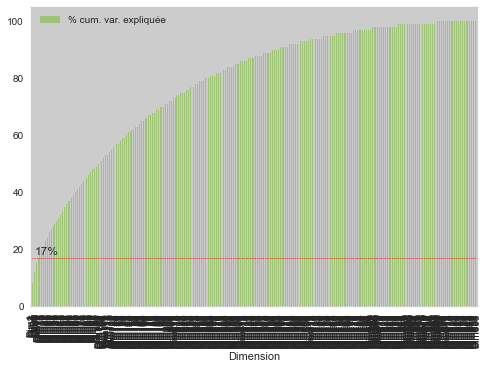

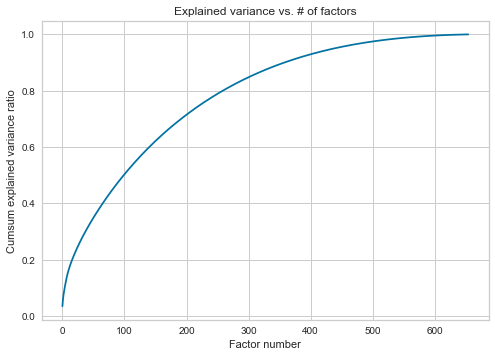

In [237]:
Z = pk_multi.amulti_acp_standard(im_features)
pk_multi.amulti_acp_choice_dim(im_features, Z)

In [24]:
im_features

array([[0.00598802, 0.00598802, 0.        , ..., 0.00399202, 0.00598802,
        0.00798403],
       [0.002     , 0.004     , 0.006     , ..., 0.        , 0.        ,
        0.002     ],
       [0.        , 0.018     , 0.002     , ..., 0.        , 0.006     ,
        0.        ],
       ...,
       [0.0060241 , 0.00301205, 0.        , ..., 0.        , 0.00903614,
        0.0060241 ],
       [0.        , 0.00653595, 0.00217865, ..., 0.        , 0.00653595,
        0.0043573 ],
       [0.        , 0.00699301, 0.        , ..., 0.        , 0.        ,
        0.00699301]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


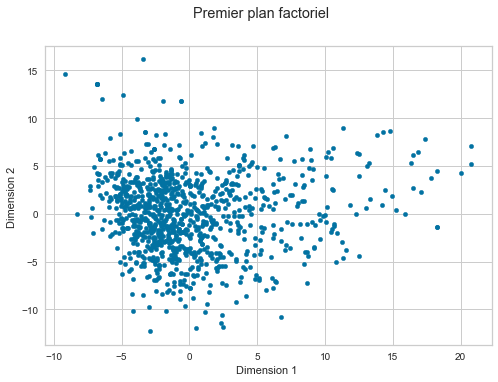

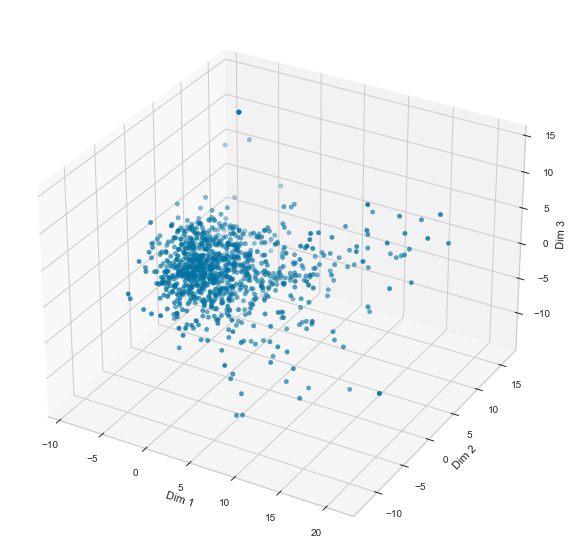

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [238]:

#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(im_features, Z, 3, im_features, data["label"], data["label"], "label",0)

In [240]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

# graph

Dimensions dataset avant réduction PCA :  (1000, 655)
Dimensions dataset après réduction PCA :  (1000, 537)


In [241]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)

(1000, 3)


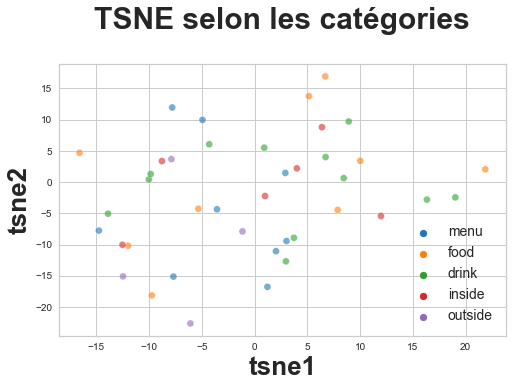

In [242]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [243]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 4)


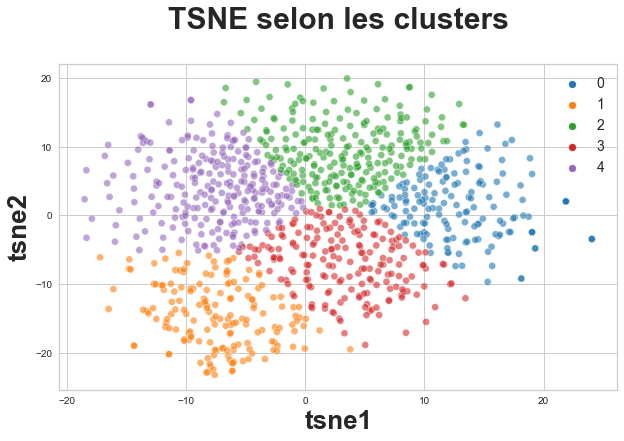

ARI :  0.11325869518099695


In [245]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [40]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    15
1    22
2    24
3    16
4    23
Name: class, dtype: int64

In [41]:
conf_mat = metrics.confusion_matrix(data["label_num"], cls.labels_)
print(conf_mat)

[[ 1  0  1  1  0]
 [ 9  5 16 13 12]
 [ 3 11  5  2  7]
 [ 0  1  0  0  1]
 [ 2  5  2  0  3]]


In [42]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [4, 3, 1, 2, 0]
[[ 0  1  1  0  1]
 [12 16 13  5  9]
 [ 7  5  2 11  3]
 [ 1  0  0  1  0]
 [ 3  2  0  5  2]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.29      0.41        55
           2       0.12      0.07      0.09        28
           3       0.05      0.50      0.08         2
           4       0.13      0.17      0.15        12

    accuracy                           0.21       100
   macro avg       0.19      0.21      0.15       100
weighted avg       0.42      0.21      0.27       100



<AxesSubplot:>

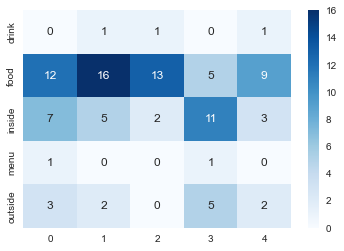

In [43]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Calculons l'ARI

# Resnet50

In [ ]:

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False

In [425]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

# false pour supprbimer la dernière couche uqi sert de classification
restnet =  ResNet50(weights='imagenet', include_top=False, pooling='avg')

restnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_10[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [ ]:
def make_model():
    # our model is based on MobileNet, but we load only the layers before the classification
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 1))
    # This loop below is needed to tell to Keras that we don t want to retrain our base model
    for layer in base_model.layers:
            layer.trainable=False

    # below, we define our own layers to perform our binary classification Cats vs. Dogs
    num_classes = 2
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

Nous créons maintenant notre modèle à l'aide de l'apprentissage par transfert à l'aide de ResNet50 pré-formé en ajoutant notre propre couche entièrement connectée et le classificateur final à l'aide de la fonction d'activation sigmoïde.

In [689]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

D:\Users\Aurel\Anaconda3\envs\venv_006\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 100352)            23587712  
                                                                 
 dense_33 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 513       
                                                                 
Total params: 75,231,617
Trainable params: 51,643,905

In [34]:
gc.collect()

586

In [57]:
data.head(2)

Empty DataFrame
Columns: [photo_id, business_id, caption, label, photo, img_corrected, img_corrected_float, label_num]
Index: []

In [43]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 224, 224, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
model (None, 224, 224, 3) float32
dense (None, 100352) float32
dropout (None, 512) float32
dense_1 (None, 512) float32


[None, None, None, None]

In [262]:
X = data["img_corrected_float"]

In [263]:
Y = data["label_num"]

In [46]:
from keras.preprocessing.image import img_to_array

In [264]:
gc.collect()

116292

In [265]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img


In [78]:

train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')

In [79]:
val_datagen = ImageDataGenerator()

In [15]:
X.shape

(200,)

In [416]:
X

res1      res2      res3      res4      res5
0    0.075362  0.749186  0.049800  0.083146  0.042507
1    0.080573  0.724464  0.051301  0.104282  0.039380
2    0.058514  0.774854  0.043806  0.092080  0.030746
3    0.072380  0.782596  0.037381  0.080149  0.027494
4    0.080513  0.718584  0.047217  0.122647  0.031039
..        ...       ...       ...       ...       ...
995  0.075112  0.738638  0.050638  0.101836  0.033776
996  0.100213  0.703421  0.050516  0.110068  0.035783
997  0.072379  0.713524  0.046478  0.127540  0.040080
998  0.067150  0.771435  0.041854  0.085498  0.034063
999  0.094922  0.696818  0.049678  0.111813  0.046769

[1000 rows x 5 columns]

In [266]:
X_keras = list(X)

In [267]:
X_keras_2 = np.array(X_keras)

In [268]:
X_keras_2.shape

(1000, 224, 224, 3)

In [269]:
Y_keras = list(Y)

In [270]:
Y_keras_2 = np.array(Y_keras)

In [271]:
X_keras_2.shape

(1000, 224, 224, 3)

In [272]:
gc.collect()

0

In [413]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
#model.add(Dense(512, activation='relu', input_dim=(224,224,3)))
#model.add(Dropout(0.3))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(5, activation='softmax'))
#model.compile(loss='binary_crossentropy',
#              optimizer=optimizers.RMSprop(lr=2e-5),
#              metrics="accuracy")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 100352)            23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [274]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [410]:
processed_image = preprocess_input(X_keras_2.copy()) 

### Extraction des features avec le Resnet50

In [427]:
predictions = restnet.predict(processed_image)

In [428]:
predictions.shape

(1000, 2048)

In [429]:
data2 = data.copy()

In [430]:
gc.collect()

138607

In [431]:
data2 = data.reset_index()

In [432]:
del data2["index"]

In [433]:
data2 = data2.reset_index()

In [434]:
df_pred = pd.DataFrame(predictions).reset_index()

In [435]:
df_pred

index    0    1    2         3         4    5    6         7         8  \
0        0  0.0  0.0  0.0  0.004921  0.000000  0.0  0.0  0.000000  0.000000   
1        1  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.016720   
2        2  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.033258   
3        3  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.002627   
4        4  0.0  0.0  0.0  0.000000  0.032476  0.0  0.0  0.001946  0.012439   
..     ...  ...  ...  ...       ...       ...  ...  ...       ...       ...   
995    995  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.000286   
996    996  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.007541   
997    997  0.0  0.0  0.0  0.000000  0.001381  0.0  0.0  0.001335  0.000793   
998    998  0.0  0.0  0.0  0.000009  0.004005  0.0  0.0  0.000000  0.000000   
999    999  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.018172   

     ...  2038      2039      2040  2041  2042  2043  2044  2045      2046  \
0    ...   0.0  0.000000  0.332585   0.0   0.0   0.0   0.0   0.0  0.002288   
1    ...   0.0  0.000000  0.295957   0.0   0.0   0.0   0.0   0.0  0.000000   
2    ...   0.0  0.000000  0.399404   0.0   0.0   0.0   0.0   0.0  0.000000   
3    ...   0.0  0.000000  0.193620   0.0   0.0   0.0   0.0   0.0  0.007692   
4    ...   0.0  0.007033  0.391696   0.0   0.0   0.0   0.0   0.0  0.000000   
..   ...   ...       ...       ...   ...   ...   ...   ...   ...       ...   
995  ...   0.0  0.000000  0.392759   0.0   0.0   0.0   0.0   0.0  0.000000   
996  ...   0.0  0.000000  0.446098   0.0   0.0   0.0   0.0   0.0  0.000000   
997  ...   0.0  0.000000  0.307323   0.0   0.0   0.0   0.0   0.0  0.000000   
998  ...   0.0  0.000000  0.239070   0.0   0.0   0.0   0.0   0.0  0.000495   
999  ...   0.0  0.000000  0.376343   0.0   0.0   0.0   0.0   0.0  0.003759   

     2047  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
..    ...  
995   0.0  
996   0.0  
997   0.0  
998   0.0  
999   0.0  

[1000 rows x 2049 columns]

In [436]:
dt = data2.merge(df_pred, how="left", on="index")

In [437]:
dt.head(2)

index                photo_id             business_id caption  label  \
0      0  VVYOvXut5IMtyYd-7sXQWQ  cQS-U82tk0mxfja01D54lQ          drink   
1      1  THbzFcnVMJb7yxC3h7XcUw  WNcGg9G-odTGz00DSMx7rg          drink   

                                               photo  \
0  input\yelp_photos\photos\VVYOvXut5IMtyYd-7sXQW...   
1  input\yelp_photos\photos\THbzFcnVMJb7yxC3h7XcU...   

                                       img_corrected  \
0  [[249, 251, 251, 251, 250, 248, 235, 210, 207,...   
1  [[207, 209, 187, 210, 212, 220, 209, 202, 181,...   

                                 img_corrected_float  \
0  [[[0.87283415, 0.9824196, 0.9705977], [0.87964...   
1  [[[0.76731825, 0.8145884, 0.81732166], [0.7872...   

                               img_corrected_float_2  label_num  ...  2038  \
0  [[0.9776613161358809, 0.9833537617634384, 0.98...          0  ...   0.0   
1  [[0.8128340067318122, 0.820122589402312, 0.733...          0  ...   0.0   

   2039      2040  2041  2042  2043  2044  2045      2046  2047  
0   0.0  0.332585   0.0   0.0   0.0   0.0   0.0  0.002288   0.0  
1   0.0  0.295957   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  

[2 rows x 2060 columns]

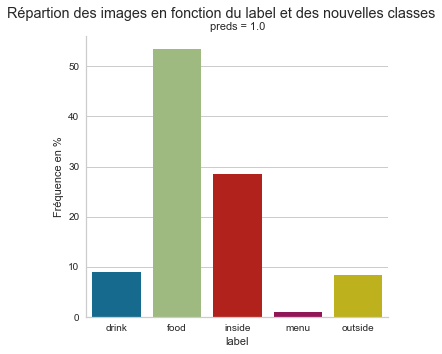

In [724]:
t = pd.crosstab(data["label"], data["preds"], normalize = "columns")
t = t.assign(label = t.index)
tm = pd.melt(t, id_vars = "label")
tm = tm.assign(value = 100 * tm.value)

ax=sns.catplot(x="label", y = "value", col = "preds", data = tm, kind = "bar")
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Répartion des images en fonction du label et des nouvelles classes")
ax.set_axis_labels("label","Fréquence en %")
plt.show()

In [100]:
gc.collect()

7

In [438]:
print(predictions.shape)

(1000, 2048)


In [439]:
from sklearn.metrics import classification_report,confusion_matrix

In [103]:
labels = data["label"].unique()

In [711]:
print(classification_report(y_test, predictions, target_names = labels))

              precision    recall  f1-score   support

      inside       0.00      0.00      0.00        57
     outside       0.53      1.00      0.69       316
       drink       0.00      0.00      0.00       174
        food       0.00      0.00      0.00         8
        menu       0.00      0.00      0.00        45

    accuracy                           0.53       600
   macro avg       0.11      0.20      0.14       600
weighted avg       0.28      0.53      0.36       600



C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
predictions

array([[0.2889456 , 0.3041395 , 0.09553263, 0.17193058, 0.13945177],
       [0.26978397, 0.31140485, 0.1298228 , 0.1844505 , 0.10453798],
       [0.29521483, 0.29345962, 0.12260329, 0.18649386, 0.10222839],
       [0.24639773, 0.30958775, 0.18075433, 0.15765403, 0.10560624],
       [0.28869125, 0.2885004 , 0.11406583, 0.18008873, 0.1286538 ],
       [0.26703286, 0.32714364, 0.13236852, 0.16509986, 0.10835518],
       [0.35120144, 0.31942126, 0.09912719, 0.11734621, 0.11290392],
       [0.31956774, 0.2963423 , 0.10671723, 0.16178899, 0.11558372],
       [0.29300138, 0.31685483, 0.10990483, 0.17663535, 0.10360362],
       [0.293855  , 0.29569268, 0.12519285, 0.17623614, 0.10902331],
       [0.2573899 , 0.30010495, 0.14293405, 0.19828606, 0.10128501],
       [0.27399725, 0.3061699 , 0.11886002, 0.17996527, 0.12100758],
       [0.34908342, 0.19717501, 0.13587452, 0.20350315, 0.11436382],
       [0.2647101 , 0.3035295 , 0.13207088, 0.19730778, 0.10238171],
       [0.3016077 , 0.23930648, 0.

In [440]:
gc.collect()

0

In [ ]:
import tensorflow as tf

def make_model(num_class, image_size):
    # our model is based on MobileNet, but we load only the layers before the classification
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # This loop below is needed to tell to Keras that we don t want to retrain our base model
    for layer in base_model.layers:
            layer.trainable=False

    # below, we define our own layers to perform our binary classification Cats vs. Dogs
    num_classes = num_class
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

### Nous réalisons une ACP pour réduire les features obtenues grâce au resnet50

In [299]:
Z = pk_multi.amulti_acp_standard(predictions)

5
[3.1609571e+00 7.0832908e-01 5.8084285e-01 5.5487531e-01 1.2037844e-12]
[6.3155931e-01 1.4152417e-01 1.1605242e-01 1.1086410e-01 2.4051616e-13]
  Dimension  Valeurs propres  % variance expliquée  % cum. var. expliquée
0      Dim1     3.157796e+00                  63.0                   63.0
1      Dim2     7.076207e-01                  14.0                   77.0
2      Dim3     5.802620e-01                  12.0                   89.0
3      Dim4     5.543205e-01                  11.0                  100.0
4      Dim5     1.202581e-12                   0.0                  100.0


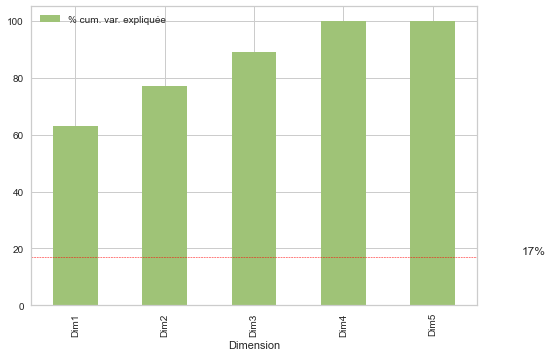

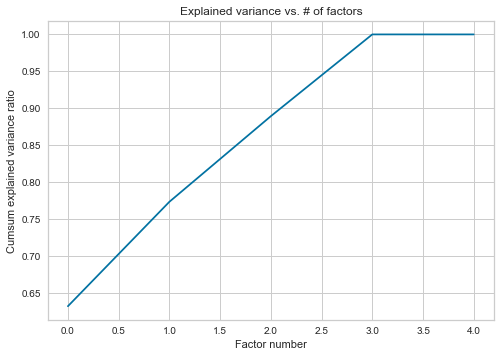

In [300]:
pk_multi.amulti_acp_choice_dim(predictions, Z)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


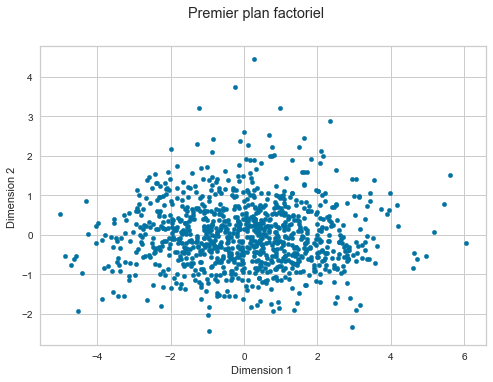

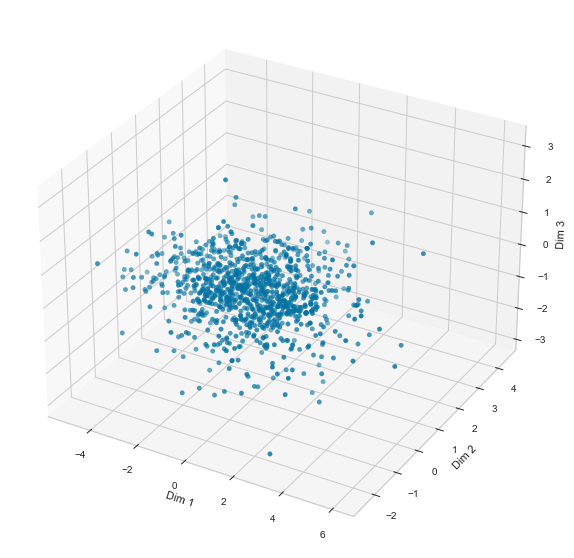

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [301]:
#pk.amultiacp_visualizer(df_acp2, Z, 3, df_acp,df_acp["customer_unique_id"], df_acp["order_id_size"], "order_id_size")
pk_multi.amultiacp_visualizer(predictions, Z, 3, predictions, data["label"], data["label"], "label",0)

In [281]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(predictions)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.280s...
[t-SNE] Computed neighbors for 1000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.007578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.529350
[t-SNE] KL divergence after 300 iterations: 0.786831


In [ ]:
tsne_results

array([[ 9.56423950e+00, -1.05777330e+01],
       [ 8.33543015e+00, -9.72628593e+00],
       [-4.38098371e-01, -2.35467005e+00],
       [ 1.05777054e+01, -6.14192581e+00],
       [-3.33944106e+00, -3.80749345e-01],
       [ 2.10075498e+00, -3.12485623e+00],
       [ 1.05489454e+01, -7.06349468e+00],
       [ 2.73245883e+00, -1.16351962e+00],
       [-5.92449141e+00,  5.44151831e+00],
       [ 3.06875420e+00, -4.47344971e+00],
       [ 4.64083338e+00, -5.05412674e+00],
       [-4.27809238e+00,  9.06593609e+00],
       [-1.80041003e+00,  2.42830491e+00],
       [ 8.03158855e+00, -3.83706260e+00],
       [ 4.06320286e+00, -1.12595100e+01],
       [ 3.08900523e+00, -1.15299101e+01],
       [ 1.05061693e+01, -1.19823675e+01],
       [ 8.64424419e+00, -1.26103001e+01],
       [-2.05237484e+00, -3.62981391e+00],
       [ 7.84590244e+00, -7.95035172e+00],
       [ 9.27349472e+00, -1.20704222e+01],
       [-2.32912517e+00, -3.15739107e+00],
       [-7.09561352e-03,  5.81265640e+00],
       [ 2.

In [ ]:
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

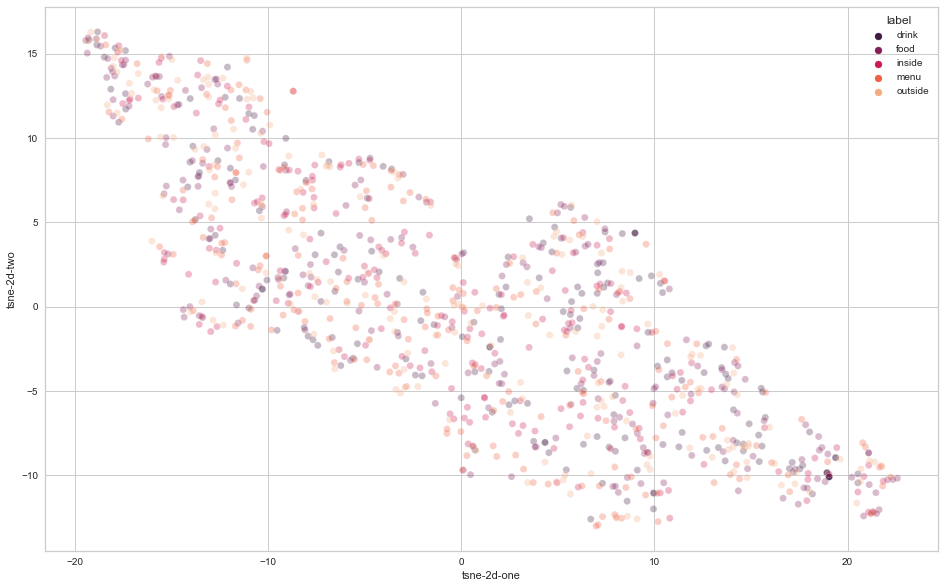

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="label",
            palette=sns.color_palette("rocket", 5),
            data=data,
            legend="full",
            alpha=0.3
        )

In [ ]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", predictions.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(predictions)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

# graph
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
def tsne_graph(df_tsne, group=0, by=""):
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(df_tsne)
    # print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    df_tsne['tsne-2d-one'] = tsne_results[:,0]
    df_tsne['tsne-2d-two'] = tsne_results[:,1]
    if group==1:
        plt.figure(figsize=(16,10))
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue=by,
            palette=sns.color_palette("rocket", 5),
            data=df_tsne,
            legend="full",
            alpha=0.3
        )
    else:  
        plt.figure(figsize=(16,10))
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            #hue="RecencyCluster",
            #palette=sns.color_palette("hls", 10),
            data=df_tsne,
            legend="full",
            alpha=0.3
        )


def umap_graphs(df_acp2):
    features = df_acp2.copy()

    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    umap_3d = UMAP(n_components=3, init='random', random_state=0)

    proj_2d = umap_2d.fit_transform(features)
    proj_3d = umap_3d.fit_transform(features)

    fig_2d = px.scatter(
        proj_2d, x=0, y=1
        #color=df.species, labels={'color': 'species'}
    )
    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2
        #color=df.species, labels={'color': 'species'}
    )
    fig_3d.update_traces(marker_size=5)

    fig_2d.show()
    fig_3d.show()

In [335]:
dt.head(2)

index                photo_id             business_id caption  label  \
0  19147  VVYOvXut5IMtyYd-7sXQWQ  cQS-U82tk0mxfja01D54lQ          drink   
1  18732  THbzFcnVMJb7yxC3h7XcUw  WNcGg9G-odTGz00DSMx7rg          drink   

                                               photo  \
0  input\yelp_photos\photos\VVYOvXut5IMtyYd-7sXQW...   
1  input\yelp_photos\photos\THbzFcnVMJb7yxC3h7XcU...   

                                       img_corrected  \
0  [[249, 251, 251, 251, 250, 248, 235, 210, 207,...   
1  [[207, 209, 187, 210, 212, 220, 209, 202, 181,...   

                                 img_corrected_float  \
0  [[[0.87283415, 0.9824196, 0.9705977], [0.87964...   
1  [[[0.76731825, 0.8145884, 0.81732166], [0.7872...   

                               img_corrected_float_2  label_num  tsne-2d-one  \
0  [[0.9776613161358809, 0.9833537617634384, 0.98...          0   -10.984679   
1  [[0.8128340067318122, 0.820122589402312, 0.733...          0     5.711198   

   tsne-2d-two   0   1   2   3   4  
0    -0.081522 NaN NaN NaN NaN NaN  
1     0.306836 NaN NaN NaN NaN NaN

In [364]:
dt.shape

(1000, 17)

In [365]:
df_km = dt[["label_num", "img_corrected_float_2", 0, 1, 2, 3, 4]]

In [366]:
df_km.columns

Index(['label_num', 'img_corrected_float_2', 0, 1, 2, 3, 4], dtype='object')

In [367]:
df_km.columns = ["label_num","img_corrected_float", "res1", "res2", "res3", "res4", "res5"]

In [368]:
df_km.shape

(1000, 7)

In [369]:
gc.collect()

576

In [370]:
X = df_km[[ "res1", "res2", "res3", "res4", "res5"]]

In [371]:
Y = df_km["label_num"]

In [372]:
df_km["img_corrected_float"].shape

(1000,)

In [373]:
X_train, X_test, y_train, y_test = pk_multi_sup.pipelineModel_TrainingSet(X,Y, 0, 0)

In [374]:
gc.collect()

0

In [375]:
X_train.head(2)

res1      res2      res3      res4      res5
140  0.082500  0.712274  0.056942  0.112195  0.036089
409  0.067317  0.795020  0.037726  0.073265  0.026672

In [376]:
X_test.head(2)

res1      res2      res3      res4      res5
890  0.074087  0.743975  0.049288  0.100163  0.032487
694  0.075587  0.713189  0.050497  0.133429  0.027298

In [377]:
def calculate_metrics(model,output):
    print('Number of clusters is {}'.format(model.n_clusters))
    print('Inertia : {}'.format(model.inertia_))
    print('Homogeneity :       {}'.format(metrics.homogeneity_score(output,model.labels_)))

In [378]:
def retrieve_info(cluster_labels,y_train):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [379]:
gc.collect()

0

In [380]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

In [381]:
gc.collect()

0

In [382]:
from sklearn import metrics
cluster_number = [4, 5, 10, 16, 20]
list_metrics = []

for i in cluster_number:
    total_clusters = len(np.unique(y_test))
    # Initialize the K-Means model
    kmeans = cluster.MiniBatchKMeans(n_clusters = i, batch_size=3073, random_state=0)
    # Fitting the model to training set
    kmeans.fit(X_train)
 
# Calculating the metrics
    
    calculate_metrics(kmeans,y_train)
    # Calculating reference_labels
    reference_labels = retrieve_info(kmeans.labels_, y_train)
    # ‘number_labels’ is a list which denotes the number displayed in image
    number_labels = np.random.rand(len(kmeans.labels_))
    for j in range(len(kmeans.labels_)):
        number_labels[j] = reference_labels[kmeans.labels_[j]]
    
    print('Accuracy score : {}'.format(metrics.accuracy_score(number_labels, y_train)))
    print('\n')
    list_metrics.append({ 'km' : kmeans, 'n_clusters': i, 'accuracy': metrics.accuracy_score(number_labels, y_train), 'inertie': kmeans.inertia_, 'homogeneite': metrics.homogeneity_score(y_train, kmeans.labels_) })

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3



Number of clusters is 4
Inertia : 0.30422934889793396
Homogeneity :       0.011594387330689588
Accuracy score : 0.24142857142857144


Number of clusters is 5
Inertia : 0.2614539563655853
Homogeneity :       0.00987454014047495
Accuracy score : 0.24142857142857144




C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3



Number of clusters is 10
Inertia : 0.1804593801498413
Homogeneity :       0.024280167301226344
Accuracy score : 0.26857142857142857


Number of clusters is 16
Inertia : 0.1402091234922409
Homogeneity :       0.035310229172179505
Accuracy score : 0.28285714285714286




C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3



Number of clusters is 20
Inertia : 0.11244893074035645
Homogeneity :       0.05565927425238798
Accuracy score : 0.3142857142857143




In [383]:
list_metrics

[{'km': MiniBatchKMeans(batch_size=3073, n_clusters=4, random_state=0),
  'n_clusters': 4,
  'accuracy': 0.24142857142857144,
  'inertie': 0.30422934889793396,
  'homogeneite': 0.011594387330689588},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=5, random_state=0),
  'n_clusters': 5,
  'accuracy': 0.24142857142857144,
  'inertie': 0.2614539563655853,
  'homogeneite': 0.00987454014047495},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=10, random_state=0),
  'n_clusters': 10,
  'accuracy': 0.26857142857142857,
  'inertie': 0.1804593801498413,
  'homogeneite': 0.024280167301226344},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=16, random_state=0),
  'n_clusters': 16,
  'accuracy': 0.28285714285714286,
  'inertie': 0.1402091234922409,
  'homogeneite': 0.035310229172179505},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=20, random_state=0),
  'n_clusters': 20,
  'accuracy': 0.3142857142857143,
  'inertie': 0.11244893074035645,
  'homogeneite': 0.05565927425238798}]

In [384]:
print(kmeans.labels_)

[10 11  8  1 10  3  1  5  2  7 10 11 17  5  4  5  9  1  4 11  3  2  8 14
 17 19  3  5 15  4  6  6 10  6  5 10  1 12  2  1  6 18  2  5 11  2  6  2
 16  6  6 10  6  6  7  5 17 11  2 17  3 12 10 17  8  3 16  7 16  2 16 14
  1  2  7 10 16  5  2 18  8  4  6  3 11  2 10 17  5  5  3  6  0  6  2  1
 12  9  4 14 12 12 14 13 12  4 10  7  3 17  3  6 11  7  3  2  5  4  1  6
  2  3 12  2 15  2  3  6 14 11 10  2 10 19 18 14 10 15 10 15 14 15  7 13
 18  2  2  6 10 15 18 12  5 17  5 15  6  6  4 17  7  9  6  6  3  3  2 17
 14 14  1  0  2 17 17  5  8  5  0 14 17  5 19  1  7  6 18 10  5  3  4  2
  5  2 10 14  2 16 18 11  8  2  4 13  6  2 10 14  5 12 15 10 17  6  1  2
  6 14 19 14  3  5  5  5  5 10 19  8  5  6  2 18 17  1  5 16  5  2 11 11
 15  1  5  1  2  1 18 11 15  7  3 16 15  6  5 17  5 16 10 14 18 10  2  4
  0  5 11  8 12 15 17  1  8  1 18  1  2 11 18  1  4  1 11 17  5  5 14  1
 14 18  5  3 12  8 10  7  4  2 13 14  7  2 17 10 10 19 14 18 17  6 17 12
 15 12  8 11  1 13  5 10 13 15 17  1 13 17  2 17  5

In [385]:
list_metrics

[{'km': MiniBatchKMeans(batch_size=3073, n_clusters=4, random_state=0),
  'n_clusters': 4,
  'accuracy': 0.24142857142857144,
  'inertie': 0.30422934889793396,
  'homogeneite': 0.011594387330689588},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=5, random_state=0),
  'n_clusters': 5,
  'accuracy': 0.24142857142857144,
  'inertie': 0.2614539563655853,
  'homogeneite': 0.00987454014047495},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=10, random_state=0),
  'n_clusters': 10,
  'accuracy': 0.26857142857142857,
  'inertie': 0.1804593801498413,
  'homogeneite': 0.024280167301226344},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=16, random_state=0),
  'n_clusters': 16,
  'accuracy': 0.28285714285714286,
  'inertie': 0.1402091234922409,
  'homogeneite': 0.035310229172179505},
 {'km': MiniBatchKMeans(batch_size=3073, n_clusters=20, random_state=0),
  'n_clusters': 20,
  'accuracy': 0.3142857142857143,
  'inertie': 0.11244893074035645,
  'homogeneite': 0.05565927425238798}]

In [386]:
df_metrics = pd.DataFrame(list_metrics)

In [387]:
df_metrics

km  n_clusters  accuracy  \
0  MiniBatchKMeans(batch_size=3073, n_clusters=4,...           4  0.241429   
1  MiniBatchKMeans(batch_size=3073, n_clusters=5,...           5  0.241429   
2  MiniBatchKMeans(batch_size=3073, n_clusters=10...          10  0.268571   
3  MiniBatchKMeans(batch_size=3073, n_clusters=16...          16  0.282857   
4  MiniBatchKMeans(batch_size=3073, n_clusters=20...          20  0.314286   

    inertie  homogeneite  
0  0.304229     0.011594  
1  0.261454     0.009875  
2  0.180459     0.024280  
3  0.140209     0.035310  
4  0.112449     0.055659

Text(0.5, 1.0, 'Training Accuracy')

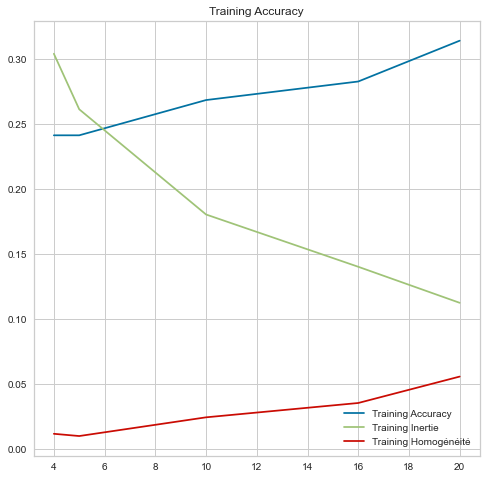

In [388]:
acc = df_metrics['accuracy']
inertie = df_metrics['inertie']
homog = df_metrics['homogeneite']
epochs_range = df_metrics["n_clusters"] # epochs
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, inertie, label='Training Inertie')
plt.plot(epochs_range, homog, label='Training Homogénéité')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

In [389]:
kmeans = cluster.MiniBatchKMeans(n_clusters = 5, batch_size=3073, random_state=0)
    # Fitting the model to training set
kmeans.fit(X_train)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=3



MiniBatchKMeans(batch_size=3073, n_clusters=5, random_state=0)

In [146]:
print(kmeans.labels_)

[1 0 3 3 1 3 3 0 0 0 4 4 0 4 3 4 1 0 2 3 1 2 3 3 2 3 4 3 0 3 2 0 0 3 0 4 3
 1 3 3 0 4 4 4 2 1 0 1 1 1 3 4 4 4 3 2 0 1 3 1 1 3 1 0 3 3 1 3 3 0 3 3 2 3
 1 0 3 3 1 3 0 4 0 1 1 1 1 0 1 3 4 1 0 3 1 4 3 3 1 1 4 1 0 3 3 1 0 3 3 0 0
 4 0 1 0 3 3 3 3 4 1 3 3 1 1 0 1 2 3 2 3 3 1 4 3 1 3 0 0 3]


In [395]:
labels = dt["label"].unique()

In [391]:
predictions_km = kmeans.fit_predict(X_test)

C:\Users\aurel\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=2



In [396]:
print(classification_report(y_test, predictions_km, target_names = labels))

              precision    recall  f1-score   support

       drink       0.17      0.10      0.13        58
        food       0.25      0.23      0.24        61
      inside       0.31      0.33      0.32        76
        menu       0.19      0.30      0.23        54
     outside       0.12      0.10      0.11        51

    accuracy                           0.22       300
   macro avg       0.21      0.21      0.20       300
weighted avg       0.22      0.22      0.21       300



In [397]:
# Since K-Means Does not know about our labels we have to change labels of k-means according to our usage

# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

Accuracy for k = 4:  0.252
Accuracy for k = 5:  0.247
Accuracy for k = 10:  0.275
Accuracy for k = 16:  0.279
Accuracy for k = 20:  0.285


Text(0, 0.5, 'Sum of squared distance')

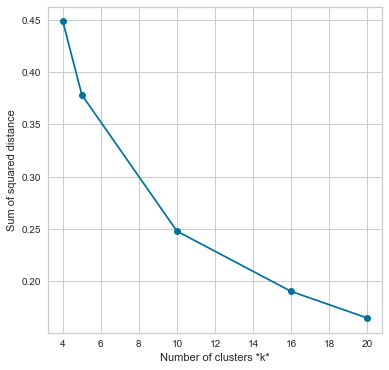

In [400]:
from sklearn.cluster import KMeans

# elbow method
# squared distance
sse = []
list_k = [4, 5, 10, 16, 20]

for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(X)
    sse.append(km.inertia_)
    
    reference_labels = get_reference_dict(clusters,Y)
    predicted_labels = get_labels(clusters,reference_labels)
    
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,Y))

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [401]:
reference_labels = get_reference_dict(predictions_km,y_test)
predicted_labels = get_labels(predictions_km,reference_labels)

In [402]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [403]:
print(accuracy_score(predicted_labels, y_test))

0.3333333333333333


In [408]:
metrics.adjusted_rand_score(y_test, predicted_labels)

0.02719477424812009

Text(0.5, 29.5, 'predicted label')

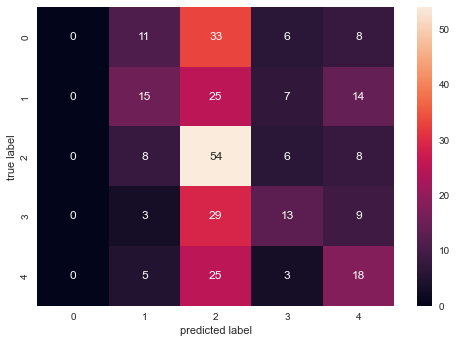

In [405]:
mat = confusion_matrix(y_test,predicted_labels)
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

In [ ]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", predictions.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(predictions)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

# graph
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")